# MULTI Manual tinkering, viewing loss traces of various models, trying to narrow in on a ballpark after skorch results

In [2]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib

import altair as alt
import seaborn as sns
import torch_utils as tu

import torch




# ReTrain some

In [3]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping,Checkpoint
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY = pd.read_csv(log_data_filename,sep='\t')

display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


In [5]:
for df in [XY]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])

In [8]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [6]:
# Exclude genes never expressed
data_filename = "data/XY_TPM_opFilt.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,52.045884,35.736190,30.829331,23.333155,44.348687,44.920897,47.861477,42.973556,64.784508,32.050358,35.462185,33.444023
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,59.991257,43.159066,33.532522,18.915775,59.629360,65.011074,79.109490,61.209155,99.002970,43.656760,41.792237,43.689839
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,33.943076,27.325800,18.491160,18.453916,28.268717,29.419165,33.534043,28.828713,44.856281,21.351623,20.644554,23.172675
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,48.648085,33.463183,31.643505,16.960643,49.839406,48.729958,48.662214,50.966799,77.842263,41.684925,34.258335,42.367072
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,27.213395,27.232565,12.892833,10.720823,27.164218,25.769601,29.013530,25.968531,19.520794,23.027211,32.713854,34.374071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,8591.278232,9584.028559,7477.339715,1298.257682,8345.785345,5934.168113,8132.547467,7157.344557,3468.582202,6497.868109,3942.957792,5085.637409
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,43.551349,26.951394,18.356915,15.624619,43.065124,43.954096,48.894308,43.386082,40.548782,26.273485,15.972203,16.423284
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,46.058548,31.889009,20.231568,26.004364,44.419579,34.993692,46.109300,36.872718,37.139500,23.525245,49.216725,44.623117
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,31.182164,23.882390,19.721043,20.960234,34.601933,32.907138,30.125207,31.899782,38.204218,26.432667,40.000662,43.201743


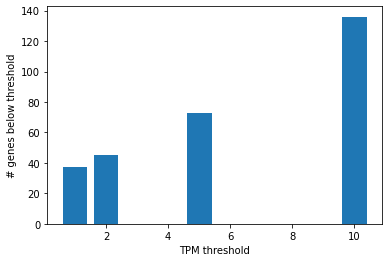

In [9]:
no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []
for i, row, in tpm_df.iterrows():
    tpms = row[conditions].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [10]:
# filter out genes that never express above 2 tpms in any condition tested
XY = XY[~XY['locus_tag'].isin(no_tx_genes2)].reset_index().drop('index',axis=1)
XY

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,gene,product
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677,dnaA,chromosomal replication initiator protein DnaA
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226,NaN,DNA polymerase III subunit beta
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353,recF,DNA replication/repair protein RecF
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872,NaN,hypothetical protein
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249,NaN,bifunctional diguanylate cyclase/phosphodieste...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,13.068657,13.226416,12.868309,10.342361,13.026832,12.534830,12.989492,12.805209,11.760130,12.665751,11.945063,12.312213,NaN,hypothetical protein
2155,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,5.444645,4.752288,4.198252,3.965749,5.428448,5.457926,5.611595,5.439160,5.341587,4.715536,3.997491,4.037671,NaN,type II toxin-antitoxin system HicA family toxin
2156,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,5.525397,4.994987,4.338536,4.700682,5.473124,5.129023,5.526986,5.204482,5.214882,4.556138,5.621077,5.479719,NaN,DUF4102 domain-containing protein
2157,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,4.962649,4.577875,4.301664,4.389583,5.112781,5.040329,4.912899,4.995475,5.255660,4.724250,5.321952,5.433018,NaN,NaN


In [5]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


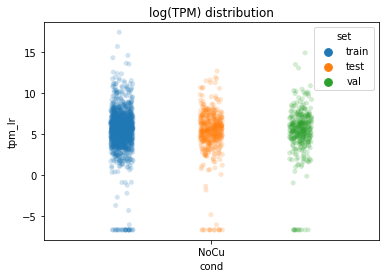

In [6]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


coi = "NoCu"
assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
view_train_test_dist(train_df, test_df,[coi],"log(TPM)",val_df=val_df)

In [7]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [9]:
Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=conditions)
print("Xtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=conditions)
print("Xval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=conditions)
print("Xtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=conditions)
print("Xfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)

Xtrain: torch.Size([1410, 300, 4])
ytrain: torch.Size([1410, 12])
Xval: torch.Size([353, 300, 4])
yval: torch.Size([353, 12])
Xtest: torch.Size([441, 300, 4])
ytest: torch.Size([441, 12])
Xfull_train: torch.Size([1763, 300, 4])
yfull_train: torch.Size([1763, 12])


In [10]:
# make skorch predefined valid ds
valid_ds = Dataset(Xval, yval)

## pick some params

In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [14]:
# just pick some
# Adam, 32 filt, fast LR
net_regr1 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=128,
    module__kernel_size1=6,
    module__kernel_size2=16,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.0,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr2 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=64,
    module__num_filters2=32,
    module__kernel_size1=6,
    module__kernel_size2=16,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 50,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

In [15]:
net_regr1.fit(Xtrain, ytrain)
net_regr2.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      265.9367       11.5035     +  1.5110
      2        6.6574        8.4876     +  0.8836
      3        6.3540       12.3709        0.6280
      4        6.6569        7.9064     +  0.6461
      5        6.2625        8.4535        0.7177
      6        6.3396        7.5387     +  0.6241
      7        6.1785        7.6539        0.6216
      8        6.2035        7.9566        0.6251
      9        6.2105        7.7093        0.6239
     10        6.1737        9.1408        0.6383
     11        6.2407        7.5361     +  0.6756
     12        6.1856        7.6071        0.6407
     13        6.1551        7.6276        0.6093
     14        6.1606        8.4641        0.6536
     15        6.2338        7.6860        0.7286
     16        6.1530        7.7040        0.6854
     17        6.1355       10.1229        0.6192
     18        6.4881        7.9487        0.6146


    151        5.1192        6.6517     +  0.6258
    152        4.0708        8.8333        0.6255
    153        4.2355       17.3667        0.6179
    154        5.0531       10.5978        0.7020
    155        4.4453        9.2786        0.6643
    156        4.2410        6.6941        0.6117
    157        3.9935        7.9652        0.6118
    158        4.0443        9.5280        0.6716
    159        4.1334        6.7250        0.6033
    160        3.8015        8.8455        0.6733
    161        3.9659        6.8427        0.6178
    162        3.6486        6.8273        0.6105
    163        3.6899       11.5192        0.6652
    164        4.3192        9.6337        0.6138
    165        3.8797        7.9288        0.6107
    166        3.7517        7.8358        0.6111
    167        3.5781        6.8722        0.6118
    168        3.5092        7.7942        0.6417
    169        3.5289        7.1286        0.6627
    170        3.3723        7.5318        0.6726


    306        1.3020        7.2052        0.6390
    307        1.6083        6.6933        0.6717
    308        1.2679        6.5933        0.6202
    309        1.3637        6.4474        0.6090
    310        1.4414        6.4284        0.6289
    311        1.4687        6.4203        0.6629
    312        1.2429        6.7269        0.6654
    313        1.3767        7.3042        0.6600
    314        1.5911        7.0756        0.6168
    315        1.4803        6.5382        0.6010
    316        1.4651        6.4889        0.6103
    317        1.2136        6.3894        0.6245
    318        1.2760        6.5640        0.6361
    319        1.5105        6.4059        0.6096
    320        1.3759        9.6916        0.6161
    321        1.8438        7.9011        0.6160
    322        1.4288        6.4287        0.6111
    323        1.2304        6.9643        0.6081
    324        1.3502        7.1917        0.6166
    325        1.3287        6.6996        0.6091


    465        0.7619        7.6514        0.6144
    466        0.9322        6.2552        0.6087
    467        0.6371        6.2116        0.6213
    468        0.6232        6.5356        0.6234
    469        0.9613        6.3300        0.6347
    470        0.5872        6.2404        0.6221
    471        0.6215        6.4606        0.6246
    472        0.6461        6.3665        0.6978
    473        0.7263        6.4411        0.6214
    474        0.6132        7.2919        0.6291
    475        0.9074        7.4188        0.6180
    476        0.9650        7.5941        0.6354
    477        0.8973        6.6689        0.6298
    478        0.6289        7.2442        0.6833
    479        0.7613        6.2305        0.6289
    480        0.5893        6.0198     +  0.6093
    481        0.5826        7.0297        0.6340
    482        0.7037        6.3768        0.7116
    483        0.6355        6.1752        0.6369
    484        0.7139        7.9445        0.6418


    625        0.5418        7.4377        0.6922
    626        0.6025        5.9893        0.7312
    627        0.4078        6.0439        0.6925
    628        0.4178        5.9176        0.6909
    629        0.3800        6.2304        0.6919
    630        0.6562        6.1028        0.7705
    631        0.5517        6.0368        0.6904
    632        0.4615        6.3612        0.6905
    633        0.7399        6.5616        0.6919
    634        0.5651        5.9301        0.6904
    635        0.3823        6.2190        0.7065
    636        0.4684        5.8423     +  0.7506
    637        0.3496        6.7128        0.7474
    638        0.7075        5.7170     +  0.6912
    639        0.4074        5.8117        0.6934
    640        0.3503        5.9455        0.6902
    641        0.5404        7.0122        0.6918
    642        0.6188        6.7802        0.7719
    643        0.5828        6.0324        0.6923
    644        0.3825        6.0404        0.7262


    788        0.3074        5.8581        0.6986
    789        0.4143        6.1120        0.7040
    790        0.4451        6.3320        0.7021
    791        0.4548        5.9663        0.7024
    792        0.3577        5.9685        0.7006
    793        0.3369        7.2380        0.7003
    794        0.5543        5.8901        0.7024
    795        0.2884        5.8356        0.7204
    796        0.2757        6.0433        0.6998
    797        0.6049        5.9734        0.7014
    798        0.3408        5.8007        0.7010
    799        0.3641        6.0209        0.7474
    800        0.4250        9.7186        0.7110
    801        0.6754        5.8620        0.7015
    802        0.3018        5.8799        0.7026
    803        0.2803        5.9412        0.7036
    804        0.3092        6.8411        0.7025
    805        0.5585        5.8457        0.7034
    806        0.2777        6.1179        0.7002
    807        0.3375        5.9849        0.7009


    951        0.2637        6.7718        0.7467
    952        0.5722        5.7303        0.7093
    953        0.2376        5.7385        0.7099
    954        0.2552        5.8050        0.7075
    955        0.2401        5.7702        0.7067
    956        0.2645        7.9043        0.7024
    957        0.8158        5.7531        0.7023
    958        0.2732        5.7498        0.7032
    959        0.3052        5.7710        0.7037
    960        0.2676        6.0158        0.7054
    961        0.2859        5.7416        0.7035
    962        0.2558        5.8351        0.7480
    963        0.2366        6.4520        0.7047
    964        0.5413        5.8202        0.7394
    965        0.2994        6.4363        0.7056
    966        0.4616        6.1194        0.7029
    967        0.2980        5.7821        0.7055
    968        0.3009        5.7483        0.7042
    969        0.2577        5.7580        0.7040
    970        0.2485        6.7660        0.7048


   1113        0.2259        5.7511        0.7026
   1114        0.3924        5.9848        0.7055
   1115        0.5043        6.4877        0.7051
   1116        0.3518        5.7299        0.7294
   1117        0.2199        5.7569        0.7478
   1118        0.2323        5.8591        0.7055
   1119        0.3614        5.6962        0.7040
   1120        0.2214        5.7491        0.7051
   1121        0.2437        5.8111        0.7050
   1122        0.3463        6.1676        0.7752
   1123        0.3514        5.7577        0.7768
   1124        0.2330        5.7678        0.7751
   1125        0.2577        6.1167        0.7762
   1126        0.4096        5.9018        0.7113
   1127        0.3185        5.6874        0.7053
   1128        0.2228        5.6666        0.7213
   1129        0.2227        6.4344        0.7446
   1130        0.4149        5.8675        0.7028
   1131        0.3463        5.6897        0.7050
   1132        0.2164        5.6915        0.7073


   1276        0.1900        5.6038        0.7369
   1277        0.3779        5.6623        0.7053
   1278        0.2078        5.5981        0.7050
   1279        0.2395        5.6956        0.7043
   1280        0.3170        6.3398        0.7507
   1281        0.3348        5.6135        0.7096
   1282        0.1983        5.6522        0.7042
   1283        0.2462        5.7422        0.7149
   1284        0.3971        6.0396        0.7058
   1285        0.2835        5.6327        0.7047
   1286        0.1997        5.7460        0.7053
   1287        0.2149        5.8075        0.7373
   1288        0.3466        5.8117        0.7042
   1289        0.2176        5.7077        0.7072
   1290        0.2795        5.6279        0.7353
   1291        0.2380        5.7729        0.7052
   1292        0.2494        5.6058        0.7042
   1293        0.2061        6.1079        0.7064
   1294        0.4822        5.7341        0.7355
   1295        0.2829        5.6510        0.7351


   1439        0.2741        5.5159        0.7860
   1440        0.2185        5.5319        0.7030
   1441        0.1771        5.7088        0.7039
   1442        0.2537        5.5506        0.7045
   1443        0.1978        5.7804        0.7030
   1444        0.3687        5.5166        0.7052
   1445        0.2102        5.5189        0.7056
   1446        0.1939        5.5142        0.7057
   1447        0.2727        5.5325        0.7878
   1448        0.2663        5.7283        0.7037
   1449        0.2457        6.1307        0.7049
   1450        0.2731        5.5715        0.7056
   1451        0.2003        5.5662        0.7021
   1452        0.1790        5.6464        0.7042
   1453        0.2712        5.7800        0.7049
   1454        0.3209        5.5394        0.7062
   1455        0.1774        5.7798        0.7835
   1456        0.2876        5.5115        0.7050
   1457        0.1841        5.5529        0.7878
   1458        0.1822        5.8374        0.7044


   1603        0.2670        5.6113        0.7048
   1604        0.1840        5.5102        0.7045
   1605        0.1970        5.5185        0.7023
   1606        0.1808        5.8029        0.7052
   1607        0.2839        5.5006        0.7027
   1608        0.1913        5.6354        0.7042
   1609        0.2410        5.8526        0.7044
   1610        0.2520        5.7105        0.7053
   1611        0.1804        5.5350        0.7043
   1612        0.1750        5.7034        0.7042
   1613        0.3306        5.5672        0.7065
   1614        0.1840        5.5638        0.7835
   1615        0.2019        5.5317        0.7326
   1616        0.2149        6.0810        0.7521
   1617        0.3120        5.6171        0.7457
   1618        0.1976        5.5314        0.8013
   1619        0.2210        5.6022        0.7304
   1620        0.2581        5.4646        0.7072
   1621        0.2318        5.4507     +  0.7016
   1622        0.1689        5.5306        0.7120


   1766        0.1557        6.1562        0.7741
   1767        0.2735        5.4969        0.7283
   1768        0.1563        5.4561        0.7842
   1769        0.1661        5.5691        0.7488
   1770        0.2998        5.5489        0.7669
   1771        0.1864        5.5267        0.7246
   1772        0.1952        5.6002        0.7064
   1773        0.1901        5.7202        0.7390
   1774        0.2408        6.1600        0.7679
   1775        0.3222        5.4849        0.7128
   1776        0.1595        5.5648        0.7856
   1777        0.1617        5.7037        0.7466
   1778        0.2743        5.4965        0.7843
   1779        0.1649        5.5011        0.7117
   1780        0.1485        5.4560        0.7366
   1781        0.2156        5.5262        0.7163
   1782        0.3149        6.0153        0.7997
   1783        0.3335        5.5144        0.7419
   1784        0.1559        5.5575        0.7401
   1785        0.1549        5.4518        0.7024


   1930        0.1470        5.7590        0.7209
   1931        0.2181        5.4916        0.7049
   1932        0.1846        5.7871        0.7043
   1933        0.2210        5.4572        0.7488
   1934        0.1550        5.4049        0.7404
   1935        0.2071        5.4959        0.7228
   1936        0.2690        5.3890     +  0.7037
   1937        0.1506        5.5295        0.7418
   1938        0.1784        5.6339        0.7507
   1939        0.2233        5.4445        0.7024
   1940        0.1513        5.4192        0.7017
   1941        0.1702        5.4776        0.7022
   1942        0.2556        5.4431        0.7290
   1943        0.1597        6.4146        0.7035
   1944        0.3992        5.5211        0.7302
   1945        0.1724        5.4375        0.7040
   1946        0.1497        5.4257        0.7017
   1947        0.1519        5.4927        0.7037
   1948        0.2031        5.4372        0.7037
   1949        0.1505        5.4274        0.7564


   2093        0.1464        5.8010        0.7169
   2094        0.3191        5.4628        0.7232
   2095        0.1539        5.4694        0.6990
   2096        0.2207        5.4297        0.6987
   2097        0.1891        5.3539        0.6990
   2098        0.1383        5.3953        0.7089
   2099        0.1958        5.4494        0.7051
   2100        0.1624        5.3667        0.6988
   2101        0.2414        5.3916        0.7009
   2102        0.2060        5.3487        0.7286
   2103        0.1401        5.3959        0.7454
   2104        0.1432        5.4527        0.7290
   2105        0.2340        5.3752        0.7389
   2106        0.1566        5.3896        0.6978
   2107        0.1678        5.3420     +  0.6989
   2108        0.1702        5.5023        0.7325
   2109        0.2806        5.4198        0.7003
   2110        0.1657        5.4349        0.7178
   2111        0.1495        5.5253        0.7315
   2112        0.2033        5.5690        0.7133


   2256        0.2728        5.3993        0.7070
   2257        0.1597        5.3287        0.7087
   2258        0.1466        5.3626        0.6976
   2259        0.1446        5.4631        0.7248
   2260        0.1671        5.3192        0.7012
   2261        0.1503        5.2920     +  0.7007
   2262        0.1738        5.2998        0.7946
   2263        0.2042        5.3851        0.7374
   2264        0.2029        5.4897        0.6991
   2265        0.2255        5.3760        0.7844
   2266        0.1824        5.3812        0.7841
   2267        0.1443        5.3613        0.7013
   2268        0.1415        5.6861        0.7382
   2269        0.2299        5.4408        0.7002
   2270        0.1624        5.4295        0.6992
   2271        0.1822        5.3687        0.7193
   2272        0.1374        5.3944        0.7004
   2273        0.1725        5.3520        0.7009
   2274        0.1386        5.3652        0.7485
   2275        0.1819        5.3292        0.6994


   2419        0.1737        5.3260        0.8013
   2420        0.1334        5.2952        0.7153
   2421        0.1430        5.2869        0.7267
   2422        0.1550        5.3648        0.6996
   2423        0.2398        5.6659        0.7756
   2424        0.2772        5.6031        0.6987
   2425        0.1826        5.3174        0.7008
   2426        0.1386        5.3004        0.6989
   2427        0.1421        5.3191        0.7272
   2428        0.1430        5.3114        0.7139
   2429        0.1673        5.3024        0.6978
   2430        0.1609        5.3440        0.7358
   2431        0.1960        5.3131        0.7363
   2432        0.1678        5.2989        0.6976
   2433        0.1636        5.2915        0.6995
   2434        0.1410        5.5115        0.6981
   2435        0.2137        5.5005        0.6976
   2436        0.2390        5.3275        0.7525
   2437        0.1656        5.4199        0.7892
   2438        0.2034        5.5337        0.7789


   2581        0.1615        5.2513        0.7012
   2582        0.1477        5.2725        0.7189
   2583        0.1569        5.3105        0.7009
   2584        0.1873        5.3341        0.7450
   2585        0.1297        5.5315        0.7029
   2586        0.2018        5.2918        0.7030
   2587        0.1346        5.5253        0.7019
   2588        0.2464        5.6235        0.7031
   2589        0.1697        5.3050        0.7414
   2590        0.1211        5.3103        0.7218
   2591        0.1409        5.3245        0.7047
   2592        0.1507        5.3337        0.7364
   2593        0.1592        5.4700        0.7042
   2594        0.1993        5.6972        0.7432
   2595        0.2172        5.2992        0.6994
   2596        0.1321        5.3487        0.7189
   2597        0.1305        5.4440        0.7007
   2598        0.1646        5.3351        0.6973
   2599        0.1524        5.2751        0.7182
   2600        0.1340        5.2721        0.6972


   2745        0.1400        5.2394        0.6963
   2746        0.1327        5.2283        0.6961
   2747        0.1263        5.6162        0.7087
   2748        0.2113        5.3043        0.6956
   2749        0.1332        5.2408        0.6956
   2750        0.1420        5.4842        0.6990
   2751        0.1837        5.4079        0.6952
   2752        0.1398        5.3700        0.7079
   2753        0.1837        5.2631        0.7415
   2754        0.1407        5.4270        0.6997
   2755        0.1577        5.4039        0.6992
   2756        0.1849        5.2904        0.7502
   2757        0.1387        5.4655        0.6989
   2758        0.2035        5.3041        0.6976
   2759        0.1325        5.2457        0.7236
   2760        0.1235        5.3773        0.7146
   2761        0.2106        5.2694        0.9000
   2762        0.1197        5.5153        0.7752
   2763        0.2352        5.3114        0.6994
   2764        0.1315        5.2579        0.7002


   2909        0.1414        5.3596        0.7079
   2910        0.1533        5.2697        0.7183
   2911        0.1238        5.4213        0.7295
   2912        0.1900        5.3898        0.7293
   2913        0.1787        5.2149        0.6978
   2914        0.1289        5.2151        0.7122
   2915        0.1316        5.2096        0.7002
   2916        0.1372        5.2436        0.6983
   2917        0.1501        5.3820        0.6968
   2918        0.1624        5.3983        0.6985
   2919        0.1512        5.2549        0.6983
   2920        0.1498        5.2868        0.6979
   2921        0.1386        5.2014        0.7262
   2922        0.1443        5.2665        0.7270
   2923        0.1747        5.3003        0.7390
   2924        0.1771        5.1978        0.7397
   2925        0.1439        5.1824        0.6982
   2926        0.1313        5.1981        0.6981
   2927        0.1222        5.2319        0.6986
   2928        0.1468        5.2723        0.7345


     67        5.8496        7.6763        0.1604
     68        5.6744        7.8287        0.1603
     69        5.8047       19.7397        0.1606
     70        6.8637       14.9717        0.1601
     71        6.4634       13.1243        0.1608
     72        6.7558        8.3708        0.1601
     73        5.8259        7.9223        0.1607
     74        5.7862        8.0122        0.1606
     75        5.6982       12.6614        0.1607
     76        6.1535        7.6554        0.1605
     77        5.7140        7.9339        0.1603
     78        5.6882        7.3252        0.1607
     79        5.6362        7.5690        0.1607
     80        5.6578        8.8882        0.1603
     81        5.8743        7.4263        0.1610
     82        5.6311        7.4829        0.1601
     83        5.6797        9.5603        0.1610
     84        5.7747        7.2860     +  0.1606
     85        5.5979        7.2673     +  0.1604
     86        5.5667       17.2166        0.1601


    220        3.0675        9.7063        0.1601
    221        3.5578        7.3537        0.1593
    222        3.1299        6.4388        0.1590
    223        2.9483        6.8541        0.1593
    224        3.0634        6.6642        0.1597
    225        3.2022       16.2615        0.1591
    226        4.5918        8.3390        0.1598
    227        3.2488       14.6344        0.1595
    228        4.1739        9.6778        0.1590
    229        3.2202        9.2781        0.1595
    230        3.0703        6.4494        0.1591
    231        2.9306        6.9622        0.1594
    232        2.9090        6.9049        0.1600
    233        2.8311        6.4509        0.1593
    234        2.7621        6.7746        0.1593
    235        2.7613        6.5235        0.1591
    236        2.6543        9.0775        0.1595
    237        3.3507        6.6040        0.1588
    238        2.6817        8.6252        0.1593
    239        3.0452        6.5267        0.1589


    378        1.8277        6.1357        0.1536
    379        1.7732        7.0885        0.1544
    380        1.8845        8.4916        0.1542
    381        2.1670        6.5077        0.1540
    382        1.8533        6.9341        0.1537
    383        1.9322        6.0369        0.1536
    384        1.7118        6.6247        0.1542
    385        1.7731        7.3441        0.1545
    386        2.0798        5.9638        0.1541
    387        1.7318        6.4161        0.1537
    388        1.9369        6.1331        0.1546
    389        1.7481        6.1109        0.1539
    390        1.9261        6.0439        0.1542
    391        1.6217       19.9401        0.1545
    392        4.1718        8.0088        0.1537
    393        1.9299        7.7489        0.1545
    394        2.0223        5.9745        0.1540
    395        1.6541        6.8504        0.1541
    396        1.9289        6.0865        0.1546
    397        1.6663        6.0769        0.1541


    538        1.4173        5.7761        0.1586
    539        1.3948        8.6748        0.1588
    540        1.7262        6.0875        0.1593
    541        1.3659        5.6804        0.1757
    542        1.3112        7.0625        0.1624
    543        1.6046        5.7837        0.1586
    544        1.3512        5.5010        0.1588
    545        1.2589        5.8077        0.1589
    546        1.4083        5.5466        0.1592
    547        1.3111        7.2102        0.1592
    548        1.6311        6.0760        0.1595
    549        1.2814        6.3719        0.1598
    550        1.4779        5.6454        0.1596
    551        1.3579        6.4532        0.1604
    552        1.3533        5.6516        0.1604
    553        1.3916        6.0146        0.1600
    554        1.4027        5.7153        0.1603
    555        1.3634        5.8317        0.1599
    556        1.3659        6.0224        0.1604
    557        1.3275        8.4058        0.1606


    700        1.2710        7.0131        0.1800
    701        1.3021        5.7157        0.1804
    702        1.2656        5.6589        0.1797
    703        1.1835        5.5898        0.1816
    704        1.2635        5.4554        0.1799
    705        1.0739        5.4381        0.1805
    706        1.1646        5.3645     +  0.1807
    707        1.1458        5.3236     +  0.1806
    708        1.1693        5.3805        0.1811
    709        1.1149        5.4421        0.1806
    710        1.1058        5.5051        0.1803
    711        1.1292        7.0614        0.1802
    712        1.5599        5.3159     +  0.1809
    713        1.0956        5.5496        0.1805
    714        1.1739        5.3556        0.1806
    715        1.2471        5.3869        0.1804
    716        1.0981        5.9787        0.1802
    717        1.2898        5.3876        0.1807
    718        1.1696        7.9111        0.1805
    719        1.3641        6.0825        0.1802


    862        1.1886        5.3704        0.1802
    863        0.9449        5.3704        0.1800
    864        1.0289        5.5045        0.1802
    865        1.0112        5.7013        0.1803
    866        1.0438        5.5986        0.1810
    867        1.1841        5.3339        0.1806
    868        1.0308        5.3169        0.1802
    869        1.0996        6.8293        0.1802
    870        1.0762        5.4518        0.1804
    871        1.1191        5.4071        0.1805
    872        1.1396        6.4206        0.1808
    873        1.0540        5.6570        0.1803
    874        1.1770        5.4593        0.1812
    875        1.0639        5.9122        0.1805
    876        1.0511        5.6114        0.1800
    877        1.1543        5.9332        0.1806
    878        0.9952        5.3642        0.1803
    879        1.0256        5.4739        0.1806
    880        1.0255        5.4608        0.1812
    881        1.0868        5.4408        0.1819


   1025        0.9234        5.3379        0.1790
   1026        0.9162        5.4495        0.1790
   1027        0.9981        5.4771        0.1797
   1028        0.9305        6.5154        0.1801
   1029        0.9727        5.4180        0.1789
   1030        0.9538        5.7273        0.1792
   1031        0.9139        5.3182        0.1789
   1032        0.9097        5.4428        0.1790
   1033        1.0006        5.2844        0.1795
   1034        0.8783        5.3997        0.1789
   1035        0.9813        5.6848        0.1793
   1036        0.9792        5.2363        0.1787
   1037        0.9242        7.5649        0.1792
   1038        1.5668        5.8034        0.1796
   1039        0.9445        5.5411        0.1789
   1040        0.9921        6.2167        0.1791
   1041        0.9509        5.2111     +  0.1792
   1042        0.8565        5.4886        0.1800
   1043        0.9158        5.7537        0.1796
   1044        1.0408        5.2146        0.1789


   1188        0.8527        9.8476        0.1779
   1189        1.8390        5.2704        0.1782
   1190        0.8469        5.5490        0.1779
   1191        0.8784        5.6347        0.1780
   1192        0.9603        6.3611        0.1780
   1193        0.8850        5.6998        0.1796
   1194        0.8179        5.2376        0.1785
   1195        0.7852        5.4094        0.1784
   1196        0.9012        5.2246        0.1779
   1197        0.8494        5.9906        0.1786
   1198        0.8903        5.8265        0.1787
   1199        0.8671        6.0629        0.1782
   1200        0.8590        6.0578        0.1782
   1201        0.8821        5.9268        0.1782
   1202        1.0122        5.3482        0.1779
   1203        0.8383        5.2975        0.1782
   1204        0.8586        5.9863        0.1780
   1205        1.1632        5.9998        0.1773
   1206        1.0512        5.2840        0.1780
   1207        0.8426        5.2304        0.1782


   1351        1.0559        5.2128        0.1759
   1352        0.7522        5.4318        0.1761
   1353        0.8551        5.6593        0.1756
   1354        0.8129        5.2460        0.1760
   1355        0.7996        5.6527        0.1763
   1356        0.9199        6.4155        0.1758
   1357        1.0955        5.1386        0.1768
   1358        0.7987        5.8510        0.1756
   1359        0.8207        5.5485        0.1761
   1360        0.7591        5.3212        0.1762
   1361        0.7917        5.6770        0.1758
   1362        0.7738        5.9157        0.1755
   1363        0.8157        5.3274        0.1758
   1364        0.7687        5.3967        0.1761
   1365        0.8150        5.1960        0.1759
   1366        0.7806        5.2647        0.1757
   1367        0.8160        5.2733        0.1766
   1368        0.7994        5.2361        0.1755
   1369        0.7727        7.1463        0.1767
   1370        1.1955        5.1850        0.1757


   1514        0.7352        5.2767        0.2034
   1515        0.7330        6.4089        0.2031
   1516        0.7679        6.8647        0.2032
   1517        0.8574        5.6262        0.2026
   1518        0.8042        6.2268        0.2031
   1519        0.8027        6.2108        0.1970
   1520        0.7755        5.8055        0.1771
   1521        0.7937        5.6954        0.1771
   1522        0.8191        5.3959        0.1774
   1523        0.7064        5.1564        0.1769
   1524        0.7985        7.5050        0.1776
   1525        1.2989        5.2355        0.1770
   1526        0.7204        5.5336        0.1776
   1527        0.7270        5.1182        0.1766
   1528        0.7747        5.4020        0.1772
   1529        0.7857        5.1218        0.1767
   1530        0.7457        5.1997        0.1771
   1531        0.7514        6.4279        0.1772
   1532        0.7812        5.5078        0.1770
   1533        0.7296        5.1164        0.1772


   1678        0.7386        5.2084        0.1768
   1679        0.6641        6.4703        0.1767
   1680        0.7833        5.3452        0.1766
   1681        0.8461        5.9017        0.1763
   1682        0.6865        5.5425        0.1767
   1683        0.8770        5.3843        0.1765
   1684        0.6424        6.2640        0.1763
   1685        0.7889        5.1645        0.1771
   1686        0.6927        5.2130        0.1767
   1687        0.7359        5.2124        0.1767
   1688        0.6797        6.3901        0.1767
   1689        1.0991        5.4166        0.1767
   1690        0.7134        5.2215        0.1764
   1691        0.7403        5.2618        0.1766
   1692        0.7255        5.3980        0.1764
   1693        0.8134        5.1670        0.1762
   1694        0.7085        5.4410        0.1801
   1695        0.7697        5.2555        0.1765
   1696        0.7149        6.5699        0.1769
   1697        0.7702        5.2461        0.1768


   1842        0.6815        5.1719        0.1778
   1843        0.7163        5.1666        0.1767
   1844        0.6710        5.4231        0.1764
   1845        0.6585        5.1189        0.1759
   1846        0.7335        5.2332        0.1767
   1847        0.6652        5.4183        0.1759
   1848        0.6998        5.2655        0.1760
   1849        0.7181        5.7591        0.1764
   1850        0.7416        5.3990        0.1764
   1851        0.6933        6.2611        0.1769
   1852        0.7547        5.2988        0.1763
   1853        0.7594        7.1709        0.1761
   1854        0.7990        5.8297        0.1762
   1855        0.7012        5.3824        0.1763
   1856        0.6604        5.4535        0.1765
   1857        0.6657        6.1091        0.1766
   1858        0.7119        7.0123        0.1758
   1859        0.7897        5.2376        0.1757
   1860        0.6740        5.6278        0.1765
   1861        0.8372        5.1678        0.1759


   2005        0.6769        5.1379        0.1767
   2006        0.6677        5.2330        0.1762
   2007        0.7249        5.7079        0.1761
   2008        0.8115        5.3042        0.1764
   2009        0.6734        5.2375        0.1762
   2010        0.6256        5.4641        0.1768
   2011        0.6346        5.2260        0.1758
   2012        0.6889        6.6699        0.1762
   2013        0.7134        5.1377        0.1761
   2014        0.6526        5.4361        0.1765
   2015        0.6541        5.1354        0.1768
   2016        0.6668        5.2639        0.1761
   2017        0.7113        6.3949        0.1763
   2018        0.6891        5.6405        0.1762
   2019        0.6497        5.1712        0.1762
   2020        0.6623        5.2752        0.1760
   2021        0.7031        5.9850        0.1762
   2022        0.6379        5.2171        0.1763
   2023        0.6299        5.3728        0.1763
   2024        0.6266        5.4947        0.1766


   2169        0.6834        5.1366        0.1769
   2170        0.6473        5.2874        0.1766
   2171        0.6334        5.5545        0.1765
   2172        0.6652        6.2954        0.1767
   2173        0.7151        5.1478        0.1762
   2174        0.6226        6.2976        0.1887
   2175        0.6992        5.6098        0.1782
   2176        0.6412        5.8012        0.1764
   2177        0.6397        6.0790        0.1760
   2178        0.6410        5.3749        0.1767
   2179        0.6644        6.7337        0.1766
   2180        1.0371        5.3227        0.1759
   2181        0.6306        5.2085        0.1763
   2182        0.5814        5.1412        0.1767
   2183        0.6566        5.2181        0.1766
   2184        0.6145        5.3030        0.1774
   2185        0.6933        5.1638        0.1761
   2186        0.6553        5.3389        0.1760
   2187        0.6673        5.1710        0.1764
   2188        0.5985        5.3947        0.1763


   2333        0.5902        5.3411        0.1767
   2334        0.5920        5.1794        0.1769
   2335        0.6035        5.4318        0.1764
   2336        0.5886        5.2655        0.1773
   2337        0.6156        5.6203        0.1764
   2338        0.6240        6.1240        0.1763
   2339        0.6725        5.5338        0.1761
   2340        0.5813        5.8100        0.1767
   2341        0.6213        5.2590        0.1859
   2342        0.6585        5.3007        0.1763
   2343        0.6764        5.2185        0.1767
   2344        0.6014        5.3369        0.1767
   2345        0.7420        5.1117        0.1772
   2346        0.6017        5.4547        0.1761
   2347        0.7161        5.3093        0.1763
   2348        0.6133        5.1306        0.1768
   2349        0.6505        5.2861        0.1764
   2350        0.5647        5.1988        0.1762
   2351        0.6409        5.3010        0.1775
   2352        0.6503        5.1039        0.1763


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 6), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 32, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=2656, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=12, bias=True)
    )
  ),
)

In [19]:
net_regr3 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=8,
    module__kernel_size2=16,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=5000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=1000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr3.fit(Xtrain,ytrain)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       26.6426       20.7236     +  0.2106
      2       19.2025       18.2204     +  0.1647
      3       16.8549       17.2681     +  0.1459
      4       14.7884       14.6634     +  0.1472
      5       12.8716       15.1133        0.1587
      6       11.8837       16.5201        0.1583
      7       10.6373       10.6491     +  0.1345
      8        9.2305       15.5991        0.1518
      9        9.5509       10.4103     +  0.1309
     10        8.2958        9.0893     +  0.1629
     11        7.7633       14.6251        0.1318
     12        8.5176        8.5225     +  0.1275
     13        7.1615        8.9438        0.1279
     14        7.0482        8.1146     +  0.1260
     15        6.7113        8.2212        0.1218
     16        6.6235        8.0347     +  0.1432
     17        6.4916        9.0169        0.1357
     18        6.4547        8.8046        0.1770


    147        4.7094        7.0826        0.1085
    148        4.8073        6.8440     +  0.1081
    149        4.7583       14.4724        0.1084
    150        5.3258        6.8298     +  0.1084
    151        4.6530        9.2358        0.1081
    152        4.8447       10.9076        0.1082
    153        4.9558        7.9397        0.1082
    154        4.6438        6.8234     +  0.1082
    155        4.5649       15.0184        0.1085
    156        5.6182        9.7280        0.1081
    157        4.7806        6.8642        0.1082
    158        4.5241        8.3783        0.1087
    159        4.7061        6.8093     +  0.1081
    160        4.5691        9.4703        0.1084
    161        4.7983        7.1713        0.1086
    162        4.5127        6.8656        0.1079
    163        4.4126        6.8315        0.1081
    164        4.5213        7.1638        0.1081
    165        4.5178        7.2591        0.1085
    166        4.4912        6.7324     +  0.1082


    303        3.5892        9.8671        0.1087
    304        3.5355        7.2755        0.1086
    305        3.2577        6.6544        0.1084
    306        3.2066        6.6073        0.1086
    307        3.0914        8.8097        0.1087
    308        3.3260        6.7147        0.1085
    309        3.1865        7.5293        0.1084
    310        3.2349        8.6762        0.1084
    311        3.3716        7.2553        0.1084
    312        3.2650        6.6984        0.1084
    313        3.1597        7.3461        0.1084
    314        3.2589        6.9758        0.1084
    315        3.1012        9.3217        0.1083
    316        3.4578        6.6301        0.1096
    317        3.1314       10.3550        0.1083
    318        3.5645        7.7796        0.1085
    319        3.2578        6.7591        0.1084
    320        3.1262        6.6239        0.1080
    321        3.0900       13.0922        0.1084
    322        3.8414        6.8873        0.1085


    462        2.6013        8.4062        0.1105
    463        2.6571        7.6032        0.1105
    464        2.6619        7.1934        0.1096
    465        2.4701        6.6716        0.1100
    466        2.4797        6.9134        0.1100
    467        2.6147        6.7750        0.1122
    468        2.5701        7.4030        0.1108
    469        2.5750        7.0460        0.1103
    470        2.5071        6.7594        0.1106
    471        2.4784        6.9223        0.1104
    472        2.6382        6.7510        0.1107
    473        2.4266       10.3520        0.1105
    474        2.6570        6.9530        0.1104
    475        2.4481        7.0710        0.1102
    476        2.4779        8.0154        0.1108
    477        2.6288       11.0143        0.1105
    478        2.9772        7.0150        0.1105
    479        2.4423        6.7418        0.1105
    480        2.4868        6.6863        0.1105
    481        2.4294        7.2760        0.1106


    623        2.4284        6.6691        0.1208
    624        2.0478        8.7994        0.1212
    625        2.4033        7.4720        0.1212
    626        2.1862        6.6050        0.1217
    627        2.0870        8.7008        0.1219
    628        2.2069        7.3613        0.1219
    629        2.2527        7.2706        0.1225
    630        2.2330        6.7567        0.1225
    631        2.1176        7.6155        0.1227
    632        2.1564        7.0420        0.1228
    633        2.2125        8.9365        0.1228
    634        2.2864        8.3220        0.1230
    635        2.1854        6.7330        0.1231
    636        2.1596        6.8759        0.1231
    637        2.1553        9.6557        0.1232
    638        2.6082        6.6481        0.1234
    639        2.0483        6.6164        0.1233
    640        2.0110        6.6384        0.1237
    641        2.0303        6.6179        0.1235
    642        2.1394        7.1168        0.1236


    784        1.9162        7.8670        0.1300
    785        2.1673        7.5421        0.1300
    786        1.9422        6.5061     +  0.1295
    787        1.9849        7.2405        0.1305
    788        1.9507        6.6925        0.1296
    789        1.9494        6.5727        0.1330
    790        1.8667        8.3693        0.1297
    791        1.9764        6.5408        0.1308
    792        1.8668        6.5232        0.1306
    793        1.8795        8.4483        0.1313
    794        2.1523        8.0790        0.1307
    795        1.9420        6.5453        0.1302
    796        1.8881        6.7825        0.1307
    797        2.0178        8.0632        0.1306
    798        2.0485        6.7659        0.1307
    799        1.9059        6.6051        0.1305
    800        1.8769        6.5175        0.1316
    801        1.8748        6.5141        0.1305
    802        1.9381        6.4535     +  0.1307
    803        1.7817        6.4926        0.1310


    946        1.8716        8.4935        0.1330
    947        1.8868        7.9300        0.1332
    948        2.2168        6.7062        0.1328
    949        1.6930        6.4727        0.1331
    950        1.8049        6.7321        0.1329
    951        1.7953        6.5710        0.1330
    952        1.7999        6.9779        0.1332
    953        1.7860        6.3242     +  0.1330
    954        1.7179        6.4175        0.1336
    955        1.7767        7.1376        0.1335
    956        2.0107        7.6210        0.1341
    957        1.8162        6.3557        0.1334
    958        1.7417        7.2566        0.1328
    959        1.7976        7.6669        0.1348
    960        1.7489        6.3537        0.1333
    961        1.8053        9.4302        0.1331
    962        1.9265        6.3678        0.1331
    963        1.8094        7.9921        0.1332
    964        1.7781        6.4303        0.1343
    965        1.8089        6.4428        0.1361


   1108        1.6357        6.6189        0.1330
   1109        1.6264        7.8645        0.1327
   1110        1.7292        8.1971        0.1345
   1111        1.7854        7.8165        0.1328
   1112        1.7659        7.7914        0.1327
   1113        1.6956        6.2196     +  0.1329
   1114        1.6687        6.7340        0.1328
   1115        1.6515        6.5078        0.1327
   1116        1.6785        6.4184        0.1326
   1117        1.8086        6.2553        0.1327
   1118        1.7335        7.9617        0.1327
   1119        1.7176        6.5472        0.1328
   1120        1.6598        9.1505        0.1329
   1121        1.8842        6.5311        0.1335
   1122        1.6420        7.4107        0.1329
   1123        1.7259        7.5175        0.1327
   1124        1.6514        6.2763        0.1327
   1125        1.6780        6.2615        0.1336
   1126        1.7404        8.0903        0.1329
   1127        1.6962        7.8931        0.1334


   1271        1.6125        6.5243        0.1448
   1272        1.5799        6.5914        0.1444
   1273        1.5556        6.2513        0.1443
   1274        1.6794        6.4016        0.1448
   1275        1.7011        6.7499        0.1446
   1276        1.5374        7.5610        0.1443
   1277        1.9635        6.2217        0.1360
   1278        1.6029        6.2402        0.1328
   1279        1.5309        6.2360        0.1328
   1280        1.5654        6.2166        0.1327
   1281        1.6064        6.2136        0.1330
   1282        1.5560        6.2209        0.1328
   1283        1.5637        6.5058        0.1329
   1284        1.5390        6.7868        0.1340
   1285        1.5632        6.6026        0.1327
   1286        1.5812        6.5321        0.1327
   1287        1.5619        6.6089        0.1326
   1288        1.5301        6.5326        0.1334
   1289        1.5899        6.3623        0.1335
   1290        1.6751        6.8233        0.1327


   1434        1.4789        6.2668        0.1340
   1435        1.4802        6.4865        0.1331
   1436        1.4436        6.7290        0.1322
   1437        1.4696        6.4334        0.1323
   1438        1.4654        6.7063        0.1323
   1439        1.5494        6.2803        0.1323
   1440        1.4766        6.3143        0.1354
   1441        1.4824        7.3317        0.1323
   1442        1.5214        7.8618        0.1325
   1443        1.5460        6.2009        0.1319
   1444        1.5619        8.6059        0.1323
   1445        1.6073        6.1118        0.1322
   1446        1.5839        7.3481        0.1320
   1447        1.5899        6.9600        0.1325
   1448        1.4817        6.1357        0.1323
   1449        1.5489        6.3759        0.1321
   1450        1.6216        6.2681        0.1327
   1451        1.5055       11.4715        0.1322
   1452        1.8245        6.3543        0.1323
   1453        1.4750        7.2177        0.1321


   1597        1.4195        6.3768        0.1330
   1598        1.4231        6.0937        0.1328
   1599        1.5190        7.2274        0.1325
   1600        1.4942       11.3435        0.1331
   1601        1.7520        6.2348        0.1345
   1602        1.5245        6.1073        0.1327
   1603        1.4531        6.7007        0.1327
   1604        1.4103        7.3298        0.1329
   1605        1.4789        6.1513        0.1328
   1606        1.4930        6.2857        0.1325
   1607        1.5489        6.6966        0.1328
   1608        1.4132        6.9240        0.1327
   1609        1.4881        6.8882        0.1327
   1610        1.3483        6.4976        0.1334
   1611        1.4506        6.1372        0.1329
   1612        1.4569        6.1589        0.1330
   1613        1.4648        6.3039        0.1356
   1614        1.4026        6.2446        0.1332
   1615        1.5050        7.9807        0.1329
   1616        1.4416        6.1628        0.1330


   1760        1.5227        7.3297        0.1301
   1761        1.4447        6.0859        0.1294
   1762        1.3826        6.3949        0.1299
   1763        1.3465        6.2312        0.1294
   1764        1.3821        6.8350        0.1298
   1765        1.3613        6.1995        0.1294
   1766        1.3730        6.3380        0.1293
   1767        1.5141        6.2607        0.1295
   1768        1.3939        6.3553        0.1294
   1769        1.4281        6.4006        0.1298
   1770        1.6123        8.5705        0.1298
   1771        1.4929        6.3185        0.1292
   1772        1.3410        8.3714        0.1295
   1773        1.4695        6.3243        0.1296
   1774        1.3764        6.4039        0.1294
   1775        1.3462        6.0447        0.1288
   1776        1.4886        6.0288     +  0.1289
   1777        1.3459        6.3673        0.1303
   1778        1.3943        7.6445        0.1297
   1779        1.3825        6.6792        0.1295


   1923        1.3095        5.9514        0.1291
   1924        1.3890        5.9618        0.1295
   1925        1.3818        6.7057        0.1297
   1926        1.3322        5.9983        0.1291
   1927        1.4125        8.0399        0.1304
   1928        1.3576        6.4106        0.1292
   1929        1.3553        6.0932        0.1346
   1930        1.5070        5.9825        0.1372
   1931        1.3575        7.8351        0.1359
   1932        1.3897        6.6682        0.1348
   1933        1.3473        6.6303        0.1291
   1934        1.3360        6.3918        0.1292
   1935        1.3283        6.9287        0.1291
   1936        1.3773        6.0227        0.1293
   1937        1.4070        8.1389        0.1295
   1938        1.3945        5.9809        0.1290
   1939        1.3838        6.6675        0.1288
   1940        1.3537        6.2380        0.1293
   1941        1.2444        7.7203        0.1291
   1942        1.3800        8.4382        0.1294


   2086        1.3467        5.8309     +  0.1311
   2087        1.3373        7.2129        0.1483
   2088        1.2937        6.4202        0.1296
   2089        1.3174        6.6567        0.1293
   2090        1.2327        6.0735        0.1294
   2091        1.2909        5.9794        0.1292
   2092        1.3668        9.4998        0.1299
   2093        1.4043        7.3982        0.1296
   2094        1.3198        7.5145        0.1295
   2095        1.3445        6.5462        0.1294
   2096        1.2432        7.9621        0.1292
   2097        1.3207        6.2616        0.1295
   2098        1.2951        6.2833        0.1293
   2099        1.3136        6.6411        0.1294
   2100        1.6188        6.0807        0.1293
   2101        1.2585        6.8821        0.1297
   2102        1.2628        6.1116        0.1292
   2103        1.2563        7.9142        0.1295
   2104        1.3420        6.5753        0.1294
   2105        1.3256        6.8594        0.1293


   2249        1.3970        5.9607        0.1293
   2250        1.2495        5.8767        0.1295
   2251        1.2822        6.6455        0.1297
   2252        1.2594        7.7684        0.1292
   2253        1.3145        9.0667        0.1309
   2254        1.4009        6.2538        0.1294
   2255        1.4292        5.8978        0.1294
   2256        1.2232        6.0316        0.1294
   2257        1.2432        5.9661        0.1294
   2258        1.2204        5.9942        0.1293
   2259        1.2283        6.0007        0.1296
   2260        1.3868        7.5099        0.1296
   2261        1.2316        6.2794        0.1296
   2262        1.2187        7.0629        0.1302
   2263        1.2943        5.8831        0.1297
   2264        1.2585        5.9146        0.1295
   2265        1.3316        5.9392        0.1292
   2266        1.3230        6.0335        0.1303
   2267        1.2488        6.0932        0.1294
   2268        1.1934        5.8903        0.1295


   2412        1.1894        6.4072        0.1295
   2413        1.1378        6.6493        0.1296
   2414        1.2302        5.8058        0.1298
   2415        1.2097        9.4756        0.1305
   2416        1.3400        6.8194        0.1300
   2417        1.2199        5.8882        0.1297
   2418        1.1968        6.1888        0.1299
   2419        1.2197        6.3488        0.1297
   2420        1.1541        7.2398        0.1295
   2421        1.1940        5.9927        0.1303
   2422        1.3960        7.4869        0.1300
   2423        1.2815        6.5949        0.1297
   2424        1.1986        5.8451        0.1295
   2425        1.1868        5.8416        0.1295
   2426        1.3124        5.9064        0.1303
   2427        1.2030        6.5659        0.1297
   2428        1.2795        6.5012        0.1296
   2429        1.2002        7.4226        0.1300
   2430        1.2430        6.0914        0.1297
   2431        1.2179        6.4911        0.1314


   2576        1.2038        7.2794        0.1309
   2577        1.2615        7.4842        0.1309
   2578        1.2531        6.5813        0.1308
   2579        1.1806        6.7438        0.1307
   2580        1.2018        5.8147        0.1316
   2581        1.3429        6.4905        0.1305
   2582        1.1830        7.1064        0.1306
   2583        1.6116        6.1329        0.1308
   2584        1.1722        5.8049        0.1305
   2585        1.2258        6.2394        0.1318
   2586        1.2073        6.4365        0.1306
   2587        1.4834        6.0709        0.1306
   2588        1.2196        6.0598        0.1303
   2589        1.1755        5.6781     +  0.1302
   2590        1.1700        5.8248        0.1503
   2591        1.1854        5.8129        0.1313
   2592        1.2126        6.1225        0.1311
   2593        1.1907        5.9009        0.1312
   2594        1.2253        6.4477        0.1309
   2595        1.1933        7.5754        0.1312


   2740        1.1758        7.9351        0.1299
   2741        1.1926        6.4392        0.1300
   2742        1.1577        7.1986        0.1298
   2743        1.2040        5.6928        0.1298
   2744        1.2208        6.1586        0.1298
   2745        1.1722        5.7247        0.1299
   2746        1.1878        5.9787        0.1298
   2747        1.1564        7.7972        0.1298
   2748        1.2551        5.9668        0.1301
   2749        1.1675        7.1496        0.1298
   2750        1.1488        5.7363        0.1297
   2751        1.1889        6.4172        0.1298
   2752        1.1786        5.6955        0.1298
   2753        1.2907        8.1254        0.1298
   2754        1.2607        6.5248        0.1300
   2755        1.1375        8.1411        0.1296
   2756        1.2304        7.7957        0.1302
   2757        1.2468        8.0475        0.1299
   2758        1.2253        8.0024        0.1296
   2759        1.2344        6.0980        0.1300


   2903        1.1305        7.6833        0.1314
   2904        1.1855        5.5968        0.1313
   2905        1.1895        6.4814        0.1351
   2906        1.1604        6.0287        0.1312
   2907        1.1548        5.7344        0.1310
   2908        1.3186        6.5246        0.1309
   2909        1.1241        5.8484        0.1312
   2910        1.1494        7.9390        0.1446
   2911        1.1804        5.7156        0.1358
   2912        1.1639        7.0032        0.1311
   2913        1.1554        6.9565        0.1329
   2914        1.1852        5.6479        0.1316
   2915        1.2117        6.8004        0.1311
   2916        1.1470        8.4300        0.1313
   2917        1.2425        6.1577        0.1310
   2918        1.1593        5.8834        0.1320
   2919        1.1491        7.3091        0.1312
   2920        1.1539        6.8934        0.1337
   2921        1.1220        5.6419        0.1310
   2922        1.2187        6.6180        0.1313


   3067        1.2956        8.2462        0.1307
   3068        1.1964        5.6579        0.1373
   3069        1.1366        5.7763        0.1631
   3070        1.1243        5.6579        0.1571
   3071        1.1704        5.5751        0.1354
   3072        1.2216        6.7693        0.1308
   3073        1.1371        5.6139        0.1305
   3074        1.1545        5.8034        0.1307
   3075        1.0852        5.7755        0.1309
   3076        1.1560        6.5408        0.1308
   3077        1.1397        8.9552        0.1303
   3078        1.3072        6.2845        0.1301
   3079        1.0935        7.3380        0.1304
   3080        1.1068        7.3928        0.1304
   3081        1.1169        5.8750        0.1304
   3082        1.1329        5.6136        0.1303
   3083        1.1276        5.6859        0.1302
   3084        1.1462        5.9212        0.1311
   3085        1.1460        5.7529        0.1304
   3086        1.1304        5.5739        0.1300


   3231        1.0971        5.9779        0.1302
   3232        1.1280        5.5663        0.1300
   3233        1.1499        5.7098        0.1309
   3234        1.1064        7.1923        0.1302
   3235        1.0885        5.5656        0.1301
   3236        1.1771        6.1651        0.1371
   3237        1.1096        5.8668        0.1370
   3238        1.1550        6.5188        0.1358
   3239        1.1535        7.0172        0.1345
   3240        1.1217        6.5673        0.1368
   3241        1.0598        6.2225        0.1371
   3242        1.1194        6.3241        0.1369
   3243        1.1138        6.1295        0.1370
   3244        1.1181        7.7468        0.1371
   3245        1.2049        8.0923        0.1337
   3246        1.1834        6.5179        0.1307
   3247        1.0847        5.8801        0.1303
   3248        1.1464        9.4547        0.1303
   3249        1.2658        6.0033        0.1302
   3250        1.0862        6.0330        0.1303


   3394        1.1136        6.1125        0.1305
   3395        1.3924        6.0798        0.1302
   3396        1.0483        5.9943        0.1303
   3397        1.1139        5.6416        0.1307
   3398        1.1036        5.8702        0.1303
   3399        1.0829        5.7257        0.1305
   3400        1.2084        5.9749        0.1303
   3401        1.0805        7.4062        0.1300
   3402        1.1215        6.0457        0.1304
   3403        1.0787        5.5645        0.1305
   3404        1.1469        5.7237        0.1304
   3405        1.1148        5.9219        0.1302
   3406        1.0654        5.6916        0.1303
   3407        1.0889        5.8228        0.1304
   3408        1.2842        6.7906        0.1303
   3409        1.0947        6.6704        0.1303
   3410        1.0775        6.4791        0.1305
   3411        1.0965        6.7184        0.1304
   3412        1.0575        5.9234        0.1302
   3413        1.1058        5.8925        0.1303


   3557        1.0986        5.5791        0.1308
   3558        1.1054        5.9659        0.1307
   3559        1.0692        5.5731        0.1306
   3560        1.1730        5.9401        0.1310
   3561        1.0757        6.0844        0.1307
   3562        1.0258        9.0987        0.1306
   3563        1.1618        9.0338        0.1307
   3564        1.2145        6.1852        0.1308
   3565        1.0502        9.0891        0.1309
   3566        1.1789        5.6583        0.1308
   3567        1.0665        7.2065        0.1307
   3568        1.1052        5.7128        0.1307
   3569        1.0923        6.3097        0.1308
   3570        1.0893        6.7543        0.1306
   3571        1.0283        6.0066        0.1308
   3572        1.0889        8.2694        0.1307
   3573        1.1079        5.7704        0.1307
   3574        1.0880        5.8464        0.1307
   3575        1.0664        6.4964        0.1314
   3576        1.0744        5.7200        0.1309


   3721        1.0277        7.4877        0.1365
   3722        1.1007        9.4849        0.1425
   3723        1.1575        5.7003        0.1430
   3724        1.0585        5.7609        0.1430
   3725        1.0941        6.4820        0.1429
   3726        1.0703        6.6092        0.1429
   3727        1.0616        7.9593        0.1423
   3728        1.0828        6.0549        0.1421
   3729        0.9960        6.4615        0.1424
   3730        1.0659        6.2668        0.1425
   3731        1.0659        7.6791        0.1422
   3732        1.0939        5.8595        0.1423
   3733        1.3553        5.5500        0.1424
   3734        1.0442        5.5781        0.1424
   3735        1.0997        5.9156        0.1422
   3736        1.0162        6.5964        0.1423
   3737        1.0658        6.2046        0.1423
   3738        1.0097        6.5771        0.1423
   3739        1.0433        6.2041        0.1424
   3740        1.0439        5.5439        0.1422


   3885        1.0927        6.7669        0.1590
   3886        1.0577        5.8601        0.1538
   3887        1.0560        6.5955        0.1794
   3888        1.0288        5.6415        0.2677
   3889        1.2477        5.6604        0.1901
   3890        1.0126        7.4000        0.1817
   3891        1.0580        5.5406        0.1607
   3892        1.0759        5.7420        0.1569
   3893        1.0839        8.2828        0.1543
   3894        1.0950        6.0651        0.1550
   3895        1.0494        6.4961        0.1542
   3896        1.0210        6.2841        0.1562
   3897        0.9751        6.1596        0.1553
   3898        1.0554        6.4749        0.1573
   3899        1.0673        7.6145        0.1870
   3900        1.1005        5.9353        0.1559
   3901        1.0614        6.4438        0.1517
   3902        1.0870        5.6703        0.2003
   3903        1.0882        8.5640        0.1359
   3904        1.1034        7.6696        0.1509


   4048        1.0002        6.5081        0.1318
   4049        0.9985        8.8486        0.1315
   4050        1.1517        6.2423        0.1319
   4051        0.9982        6.4412        0.1315
   4052        1.0049        6.9850        0.1314
   4053        1.0535        6.9327        0.1342
   4054        1.0642        5.7577        0.1390
   4055        1.0658        5.6740        0.1310
   4056        1.2037        5.8230        0.1310
   4057        1.0486        5.8538        0.1310
   4058        1.0106        5.8090        0.1311
   4059        0.9782        7.5650        0.1473
   4060        1.0686        6.2611        0.1314
   4061        1.0235        6.7693        0.1314
   4062        1.0518        5.4393        0.1311
   4063        1.0860        9.4451        0.1311
   4064        1.0961        7.8374        0.1320
   4065        1.0199        6.9756        0.1310
   4066        1.0213        5.6929        0.1314
   4067        1.0652        6.3134        0.1311


   4212        1.0076        5.5438        0.1319
   4213        1.0314        5.4414        0.1320
   4214        1.0921        6.9836        0.1320
   4215        1.0269        5.4751        0.1319
   4216        1.0501        6.1373        0.1317
   4217        1.0073        5.9312        0.1327
   4218        1.2801        8.5396        0.1361
   4219        1.0987        6.3215        0.1321
   4220        1.0222        5.5996        0.1321
   4221        0.9746        5.4047        0.1320
   4222        1.1002        5.4845        0.1320
   4223        1.0590        5.9338        0.1319
   4224        0.9867        8.5019        0.1317
   4225        1.0778        5.9739        0.1317
   4226        1.0292        6.0871        0.1318
   4227        0.9824        6.6560        0.1317
   4228        0.9700        5.4351        0.1316
   4229        1.0951        7.2767        0.1317
   4230        1.0007        6.3633        0.1318
   4231        0.9998        5.8010        0.1320


   4375        1.0459        5.5020        0.1387
   4376        1.0171        5.6591        0.1387
   4377        1.0114        6.3219        0.1386
   4378        1.0008        6.5188        0.1385
   4379        1.0413        7.3570        0.1371
   4380        1.0605        5.4678        0.1318
   4381        1.0356        5.4145        0.1319
   4382        1.0181        7.9286        0.1319
   4383        1.0472        6.3210        0.1320
   4384        0.9934        6.4988        0.1319
   4385        1.0048        9.0979        0.1319
   4386        1.1522        6.4057        0.1319
   4387        0.9858        5.4208        0.1319
   4388        1.0479        6.2269        0.1321
   4389        0.9860        6.1775        0.1338
   4390        1.0525        6.7017        0.1319
   4391        1.0471        5.8042        0.1361
   4392        0.9776        5.3270        0.1432
   4393        1.1281        6.7966        0.1434
   4394        0.9886        5.8754        0.1434


   4539        0.9869        5.5041        0.1319
   4540        1.0393        6.4479        0.1316
   4541        0.9937        5.8308        0.1315
   4542        0.9571        6.1411        0.1313
   4543        0.9982        7.3062        0.1314
   4544        1.0081        5.9154        0.1313
   4545        0.9833        5.4337        0.1316
   4546        1.0009        6.4826        0.1314
   4547        0.9745        8.0183        0.1314
   4548        1.0432        7.2747        0.1316
   4549        1.0204        5.3766        0.1317
   4550        1.1118        5.6526        0.1315
   4551        0.9758        5.3145        0.1317
   4552        1.1162        9.1118        0.1314
   4553        1.1235        7.5547        0.1317
   4554        0.9816        6.0148        0.1315
   4555        1.0006        5.7096        0.1315
   4556        1.0005        5.6742        0.1315
   4557        1.0095        6.9542        0.1323
   4558        1.0115        7.0385        0.1314


   4702        1.2227        6.1061        0.1315
   4703        0.9552        5.5858        0.1314
   4704        0.9770        7.3337        0.1316
   4705        0.9739        5.8482        0.1324
   4706        0.9380        9.1057        0.1316
   4707        1.1643        5.8388        0.1315
   4708        0.9575        6.3054        0.1320
   4709        0.9899        7.7521        0.1315
   4710        0.9918        5.7282        0.1325
   4711        0.9713        5.7535        0.1317
   4712        0.9936        6.3512        0.1317
   4713        1.0034        5.9388        0.1315
   4714        0.9584        5.7740        0.1313
   4715        0.9696        5.6219        0.1314
   4716        0.9642        6.7265        0.1314
   4717        0.9849        5.9472        0.1317
   4718        1.0075        8.9848        0.1317
   4719        1.1198        6.3466        0.1314
   4720        0.9526        9.4838        0.1318
   4721        1.1304        5.4974        0.1315


   4866        1.0030        6.3718        0.1316
   4867        0.9795        5.9467        0.1315
   4868        0.9976        6.1568        0.1316
   4869        0.9715        5.3385        0.1316
   4870        1.0124        6.1739        0.1316
   4871        0.9616        7.8547        0.1317
   4872        1.0439        6.3715        0.1317
   4873        0.9987        5.6790        0.1320
   4874        0.9745        5.5134        0.1316
   4875        1.0049        5.4710        0.1329
   4876        0.9446        7.2804        0.1316
   4877        0.9973        6.8247        0.1316
   4878        0.9806        7.3638        0.1315
   4879        1.0158        7.7138        0.1316
   4880        0.9715        5.2870     +  0.1348
   4881        1.0687        7.8370        0.1944
   4882        1.0169        6.4816        0.1686
   4883        0.9716        9.8226        0.1604
   4884        1.1275        6.0874        0.1723
   4885        0.9592        6.2283        0.1665


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten(start_dim=1, end_dim=-1)
      (8): Linear(in_features=2624, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=12, bias=True)
    )
  ),
)

In [17]:
net_regr4 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=32,
    module__conv_pool_size1=6, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr4.fit(Xtrain,ytrain)

final linear_node_num: 512
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       26.2438        8.6495     +  0.0572
      2        9.5410        8.8258        0.0565
      3        8.1544        8.6325     +  0.0554
      4        7.4870        8.6199     +  0.0554
      5        7.4128        8.6125     +  0.0555
      6        7.3275        8.6611        0.0554
      7        7.3257        8.6094     +  0.0554
      8        7.1622        8.7356        0.0555
      9        7.4805        8.5923     +  0.0553
     10        7.0781        8.5769     +  0.0554
     11        7.8376        8.6731        0.0558
     12        7.3143        8.6213        0.0555
     13        7.5491        8.8351        0.0555
     14        7.1223        8.8159        0.0556
     15        8.4361        8.7312        0.0561
     16        7.4737        8.5528     +  0.0556
     17        7.0941        8.7106        0.0556
     18        7.1293  

    149        5.9915        8.0982        0.0481
    150        5.8213        8.0664        0.0475
    151        5.8723        8.2469        0.0475
    152        5.9289        8.0920        0.0472
    153        5.8275        8.1427        0.0471
    154        5.8661        8.4891        0.0472
    155        6.0567        8.2457        0.0547
    156        5.8106        8.0898        0.0464
    157        5.8496        8.6127        0.0464
    158        6.2501        8.6162        0.0465
    159        6.0453        8.5102        0.0463
    160        5.7839        8.0136     +  0.0463
    161        5.6518        7.9877     +  0.0476
    162        5.6531        8.0269        0.0469
    163        5.5677        7.9877     +  0.0470
    164        5.6775        8.1404        0.0469
    165        5.5359        7.9641     +  0.0468
    166        5.5111        8.0013        0.0467
    167        5.8037        8.3370        0.0466
    168        5.4066        7.9616     +  0.0467


    299        3.4488        6.6147        0.0471
    300        3.4678        7.1327        0.0479
    301        3.7279        6.5568        0.0480
    302        3.4176        6.8334        0.0470
    303        3.8761        7.2721        0.0539
    304        3.8004        6.6328        0.0472
    305        3.4795        6.5795        0.0471
    306        3.5518        6.6285        0.0466
    307        3.4197        6.5536        0.0466
    308        3.3789        6.5761        0.0471
    309        3.4787        6.6843        0.0476
    310        3.3848        6.5613        0.0468
    311        3.2434        6.5461        0.0468
    312        3.3648        6.5512        0.0466
    313        3.2105        6.6429        0.0464
    314        3.4198        6.6127        0.0466
    315        3.2777        6.5761        0.0465
    316        3.1668        6.8640        0.0464
    317        3.4113        6.7343        0.0470
    318        3.2438        6.5729        0.0470


    457        2.6134        6.2650        0.0534
    458        2.3714        6.2765        0.0532
    459        2.3151        6.3797        0.0533
    460        2.8790        6.4024        0.0535
    461        2.7086        6.2878        0.0535
    462        2.5495        6.5123        0.0535
    463        2.7253        6.6278        0.0534
    464        2.5982        6.2031        0.0536
    465        2.4869        6.2128        0.0534
    466        2.6238        6.4239        0.0536
    467        2.6838        6.3267        0.0536
    468        2.6725        6.4264        0.0536
    469        2.5505        6.2221        0.0537
    470        2.4881        6.2073        0.0535
    471        2.4388        6.1959        0.0537
    472        2.4527        6.2113        0.0536
    473        2.6573        6.2484        0.0536
    474        2.6129        6.3302        0.0534
    475        2.5957        6.2740        0.0534
    476        2.4709        6.2772        0.0533


    618        2.1397        6.1462        0.0477
    619        2.0893        6.0488        0.0477
    620        2.1256        6.0114        0.0474
    621        2.0344        6.0461        0.0475
    622        2.1306        6.0542        0.0475
    623        2.1879        6.0370        0.0473
    624        2.0743        6.0822        0.0473
    625        2.1627        6.1764        0.0472
    626        2.0684        6.1095        0.0480
    627        2.0416        6.0028        0.0477
    628        2.0532        6.0180        0.0475
    629        2.0503        6.1495        0.0476
    630        2.1440        6.0599        0.0476
    631        2.0462        6.1271        0.0475
    632        2.0244        5.9920        0.0475
    633        2.2014        6.3421        0.0476
    634        2.0535        6.0553        0.0475
    635        2.0477        6.0909        0.0473
    636        2.1415        6.3410        0.0473
    637        1.9750        6.0040        0.0473


    780        1.9031        6.2916        0.0556
    781        1.8539        6.2702        0.0554
    782        1.9323        6.1978        0.0554
    783        1.8103        6.5591        0.0551
    784        1.9603        6.2735        0.0551
    785        1.8969        6.2076        0.0551
    786        1.7917        6.2129        0.0552
    787        1.7704        6.2756        0.0551
    788        1.8870        6.5945        0.0551
    789        2.6089        6.0793        0.0550
    790        2.3170        6.8706        0.0550
    791        2.0360        6.2803        0.0551
    792        2.0353        6.7578        0.0552
    793        2.0368        6.2486        0.0554
    794        2.0404        6.4908        0.0552
    795        2.1104        6.1155        0.0552
    796        1.9389        6.4199        0.0558
    797        1.8358        6.1760        0.0554
    798        2.0460        6.3988        0.0557
    799        1.8590        6.3494        0.0556


    944        1.7243        6.2086        0.0554
    945        1.6812        6.7417        0.0561
    946        1.6690        6.1985        0.0559
    947        1.5556        6.3794        0.0557
    948        1.7121        6.6450        0.0556
    949        1.8237        6.1908        0.0556
    950        1.7910        6.3459        0.0484
    951        1.7103        6.5987        0.0483
    952        1.7417        6.3622        0.0523
    953        1.7348        6.3522        0.0540
    954        1.7097        6.3739        0.0474
    955        1.8107        6.8552        0.0538
    956        1.8174        6.1575        0.0473
    957        1.6714        6.5302        0.0474
    958        1.7135        6.3221        0.0474
    959        1.6966        6.4602        0.0474
    960        1.5343        6.3324        0.0537
    961        1.6248        6.4054        0.0473
    962        1.7459        6.4406        0.0474
    963        1.7198        6.4191        0.0478


   1107        1.5207        6.4204        0.0480
   1108        1.5277        6.5249        0.0482
   1109        1.5629        6.4282        0.0482
   1110        1.4812        6.4497        0.0482
   1111        1.4966        7.0598        0.0482
   1112        2.0736        6.2715        0.0481
   1113        1.7109        6.7561        0.0481
   1114        1.7315        6.4188        0.0480
   1115        1.5925        6.6093        0.0480
   1116        1.5757        6.3830        0.0479
   1117        1.6252        6.5426        0.0483
   1118        1.5985        6.5837        0.0483
   1119        1.6265        6.7619        0.0482
   1120        1.6527        6.4562        0.0482
   1121        1.6185        6.3559        0.0483
   1122        1.6782        6.7011        0.0481
   1123        1.7039        6.3043        0.0537
   1124        1.5950        6.8412        0.0540
   1125        1.7393        6.2571        0.0541
   1126        1.6393        6.9787        0.0543


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=512, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [18]:
net_regr5 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=32,
    module__conv_pool_size1=8, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=2000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr5.fit(Xtrain,ytrain)

final linear_node_num: 128
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       27.2475       12.4379     +  0.0541
      2        9.1622        9.7498     +  0.0531
      3        8.1287        9.3825     +  0.0539
      4        7.9771        8.7027     +  0.0471
      5        7.7694        8.5868     +  0.0470
      6        7.3479        8.5811     +  0.0470
      7        7.4476        8.5707     +  0.0476
      8        7.6394        8.5899        0.0474
      9        7.4272        8.5651     +  0.0472
     10        7.6073        8.5522     +  0.0470
     11        7.3124        8.5463     +  0.0469
     12        7.2563        8.5544        0.0469
     13        7.5642        8.5214     +  0.0468
     14        7.2285        8.5540        0.0469
     15        7.2972        8.5117     +  0.0468
     16        7.5786        8.5093     +  0.0469
     17        7.5120        8.5047     +  0.0466
     18        7.2063  

    144        5.5389        7.4203        0.0535
    145        5.3743        7.8084        0.0532
    146        5.7369        7.5912        0.0534
    147        5.5272        8.0678        0.0531
    148        5.8061        7.4211        0.0530
    149        5.5320        7.3448     +  0.0529
    150        5.5270        7.6194        0.0530
    151        5.2595        7.3201     +  0.0529
    152        5.4269        7.3125     +  0.0530
    153        5.4384        7.4703        0.0531
    154        5.3370        7.2948     +  0.0530
    155        5.4002        7.2867     +  0.0529
    156        5.4789        7.9334        0.0532
    157        5.4437        7.3413        0.0532
    158        5.3568        7.2565     +  0.0529
    159        5.7158        7.4807        0.0560
    160        5.1243        7.2360     +  0.0556
    161        5.2371        7.2498        0.0560
    162        5.0844        7.2170     +  0.0556
    163        5.2664        7.2322        0.0557


    296        3.4965        6.0710        0.0469
    297        3.5164        6.2353        0.0468
    298        3.5313        5.9544        0.0468
    299        3.3112        5.9567        0.0467
    300        3.0453        5.9272        0.0481
    301        3.1077        6.0013        0.0480
    302        3.2219        5.9134        0.0467
    303        3.4184        6.0595        0.0477
    304        3.2577        5.9187        0.0533
    305        3.3662        6.0401        0.0469
    306        3.4264        5.8079     +  0.0469
    307        3.1828        5.9562        0.0464
    308        3.1340        5.9020        0.0533
    309        3.0541        5.9021        0.0468
    310        3.3121        5.9968        0.0471
    311        3.1939        5.8409        0.0471
    312        3.3795        5.9179        0.0470
    313        3.1391        5.8816        0.0473
    314        3.1547        5.9585        0.0472
    315        3.1404        5.8624        0.0472


    458        2.6718        5.9343        0.0481
    459        2.5265        6.0960        0.0481
    460        2.6885        6.2534        0.0483
    461        2.9863        6.2438        0.0482
    462        2.6103        6.0079        0.0480
    463        2.5675        5.9591        0.0481
    464        2.6341        6.0394        0.0480
    465        2.6958        5.9955        0.0480
    466        2.6587        6.1102        0.0480
    467        2.6700        5.9710        0.0482
    468        2.6359        6.3271        0.0480
    469        2.8213        6.0293        0.0478
    470        2.8165        6.0672        0.0479
    471        2.5898        5.9727        0.0479
    472        2.5809        5.9838        0.0483
    473        2.8237        6.0031        0.0479
    474        2.3970        6.0054        0.0477
    475        2.7127        5.9859        0.0478
    476        2.5828        5.9510        0.0472
    477        2.6157        5.8981        0.0527


    621        2.4896        6.0936        0.0477
    622        2.1557        6.0840        0.0476
    623        2.2836        6.0937        0.0478
    624        2.2096        6.0738        0.0477
    625        2.4005        6.0335        0.0476
    626        2.1722        6.0983        0.0476
    627        2.2704        6.0967        0.0476
    628        2.2093        6.0780        0.0477
    629        2.1468        6.0657        0.0476
    630        1.9913        6.0443        0.0479
    631        2.3887        6.1081        0.0480
    632        2.1461        6.0945        0.0477
    633        2.3829        6.0864        0.0480
    634        2.1203        6.0704        0.0481
    635        2.2036        6.0894        0.0479
    636        2.1835        6.1035        0.0480
    637        2.3168        6.0640        0.0480
    638        2.1869        6.0701        0.0479
    639        2.2786        6.0573        0.0475
    640        2.3242        6.0974        0.0474


    784        2.0823        6.0912        0.0539
    785        2.0336        6.0617        0.0534
    786        1.9562        6.0606        0.0534
    787        2.0528        6.0815        0.0534
    788        2.1808        6.1055        0.0540
    789        2.3174        6.1026        0.0540
    790        1.9305        6.0996        0.0540
    791        1.9742        6.0993        0.0542
    792        1.9023        6.1308        0.0537
    793        1.9083        6.1143        0.0535
    794        1.9589        6.1139        0.0534
    795        1.9065        6.0981        0.0535
    796        1.9258        6.1328        0.0534
    797        2.1427        6.0930        0.0534
    798        2.0702        6.0890        0.0533
    799        1.9758        6.0453        0.0537
    800        1.9212        6.1153        0.0537
    801        1.9657        6.0716        0.0537
    802        2.0246        6.1305        0.0537
    803        1.9578        6.0709        0.0536


    947        1.9184        6.0616        0.0551
    948        1.8049        6.0342        0.0555
    949        1.7742        6.0410        0.0555
    950        1.9265        6.1571        0.0554
    951        2.0944        6.4114        0.0554
    952        2.1387        6.2824        0.0553
    953        1.9337        6.1332        0.0558
    954        2.0716        6.1814        0.0555
    955        1.9568        6.1886        0.0552
    956        1.9657        6.1297        0.0551
    957        2.0260        6.1123        0.0552
    958        1.8033        6.1072        0.0551
    959        1.8773        6.1059        0.0552
    960        1.9174        6.1202        0.0550
    961        1.9390        6.2004        0.0550
    962        2.1191        6.1441        0.0549
    963        2.0357        6.0597        0.0556
    964        1.9504        6.0696        0.0558
    965        1.9091        6.0673        0.0555
    966        1.8971        6.0607        0.0555


   1111        1.6758        6.0632        0.0536
   1112        1.7502        6.1364        0.0536
   1113        1.8710        6.1024        0.0537
   1114        1.7624        6.0698        0.0536
   1115        1.7301        6.0454        0.0536
   1116        1.6868        6.0841        0.0535
   1117        1.7052        6.0944        0.0537
   1118        1.7303        6.0599        0.0541
   1119        1.7729        6.0893        0.0540
   1120        1.7675        6.0916        0.0542
   1121        1.6685        6.0699        0.0543
   1122        1.7685        6.0596        0.0516
   1123        1.5751        6.0535        0.0493
   1124        1.7007        6.0719        0.0490
   1125        1.7237        6.1015        0.0493
   1126        1.7233        6.0902        0.0487
   1127        1.8602        6.0888        0.0484
   1128        1.6691        6.1176        0.0484
   1129        1.8054        6.1514        0.0483
   1130        1.6954        6.1407        0.0485


   1275        1.5377        5.9333        0.0474
   1276        1.6786        5.9526        0.0469
   1277        1.5651        5.9580        0.0540
   1278        1.7251        5.9597        0.0473
   1279        1.6291        5.9359        0.0474
   1280        1.6579        5.9223        0.0470
   1281        1.5931        5.9410        0.0475
   1282        1.5749        5.9256        0.0475
   1283        1.5369        5.9065        0.0475
   1284        1.5123        5.8973        0.0471
   1285        1.6064        5.9056        0.0477
   1286        1.5957        5.9024        0.0480
   1287        1.5980        5.9090        0.0478
   1288        1.5766        5.9097        0.0473
   1289        1.5020        5.9244        0.0542
   1290        1.5188        5.9314        0.0542
   1291        1.5982        5.9255        0.0469
   1292        1.5381        5.9496        0.0536
   1293        1.6587        5.9684        0.0537
   1294        1.6794        5.9502        0.0540


   1438        1.6222        5.9272        0.0479
   1439        1.5820        5.9271        0.0481
   1440        1.5360        5.9510        0.0480
   1441        1.4872        5.9453        0.0480
   1442        1.4711        5.9245        0.0480
   1443        1.5558        5.9323        0.0480
   1444        1.5715        5.9204        0.0482
   1445        1.4585        5.9645        0.0483
   1446        1.5800        5.9657        0.0483
   1447        1.5019        5.9487        0.0481
   1448        1.5736        5.9383        0.0481
   1449        1.5734        5.9643        0.0481
   1450        1.4646        5.9559        0.0499
   1451        1.6425        5.9751        0.0550
   1452        1.5598        5.9891        0.0550
   1453        1.5534        5.9671        0.0547
   1454        1.4203        5.9296        0.0547
   1455        1.4746        5.9388        0.0550
   1456        1.5649        5.9213        0.0549
   1457        1.5159        5.9296        0.0549


   1602        1.5133        5.9872        0.0482
   1603        1.4669        6.0203        0.0481
   1604        1.5145        5.9797        0.0482
   1605        1.4501        5.9688        0.0482
   1606        1.5449        5.9404        0.0486
   1607        1.5134        5.9577        0.0485
   1608        1.5262        5.9553        0.0518
   1609        1.4320        5.9735        0.0566
   1610        1.5407        5.9787        0.0566
   1611        1.4951        6.0111        0.0567
   1612        1.4777        5.9982        0.0550
   1613        1.4814        6.0011        0.0548
   1614        1.6249        6.1016        0.0546
   1615        1.4825        6.0482        0.0543
   1616        1.5354        6.1832        0.0542
   1617        1.5292        6.1913        0.0540
   1618        1.5099        6.1110        0.0541
   1619        1.6455        6.1265        0.0540
   1620        1.4533        6.0902        0.0541
   1621        1.4360        6.0613        0.0540


   1766        1.4249        5.9668        0.0546
   1767        1.4126        5.9553        0.0544
   1768        1.8434        5.8872        0.0545
   1769        1.6952        5.9949        0.0551
   1770        1.4066        5.8983        0.0546
   1771        1.5182        5.9329        0.0558
   1772        1.4725        5.8991        0.0558
   1773        1.6230        5.9152        0.0543
   1774        1.5808        5.9318        0.0540
   1775        1.5385        5.9396        0.0545
   1776        1.4780        5.8656        0.0539
   1777        1.4275        5.8940        0.0539
   1778        1.3882        5.8967        0.0546
   1779        1.3976        5.8892        0.0543
   1780        1.4588        5.8927        0.0539
   1781        1.5976        5.8894        0.0540
   1782        1.3968        5.8662        0.0545
   1783        1.5302        5.8631        0.0541
   1784        1.5058        5.8695        0.0541
   1785        1.4329        5.9029        0.0539


   1930        1.4557        5.9480        0.0560
   1931        1.5228        6.0105        0.0560
   1932        1.4581        5.9258        0.0559
   1933        1.4489        5.9800        0.0559
   1934        1.5151        5.9587        0.0560
   1935        1.4479        5.9640        0.0519
   1936        1.4426        5.9640        0.0489
   1937        1.3000        5.9664        0.0564
   1938        1.4603        5.9722        0.0556
   1939        1.3264        5.9738        0.0558
   1940        1.2911        5.9560        0.0556
   1941        1.5290        5.9658        0.0556
   1942        1.3727        5.9092        0.0556
   1943        1.3528        5.9190        0.0556
   1944        1.3927        5.9417        0.0555
   1945        1.4139        5.9329        0.0556
   1946        1.3597        5.9220        0.0557
   1947        1.3813        5.9501        0.0556
   1948        1.5578        5.9195        0.0556
   1949        1.5144        5.8949        0.0557


   2094        1.3315        6.0026        0.0490
   2095        1.2369        5.9641        0.0486
   2096        1.3466        5.9902        0.0490
   2097        1.3862        5.9674        0.0558
   2098        1.3043        5.9557        0.0562
   2099        1.3615        5.9339        0.0556
   2100        1.2613        5.9225        0.0555
   2101        1.3810        5.9412        0.0557
   2102        1.3300        5.9455        0.0557
   2103        1.3292        5.9414        0.0557
   2104        1.3631        5.9258        0.0558
   2105        1.3561        5.9241        0.0553
   2106        1.3533        5.9855        0.0538
   2107        1.3772        6.0085        0.0548
   2108        1.3503        6.0640        0.0478
   2109        1.3732        5.9920        0.0481
   2110        1.2996        5.9910        0.0478
   2111        1.2729        6.0359        0.0476
   2112        1.3818        6.0474        0.0478
   2113        1.2781        6.0622        0.0478


   2258        1.4160        6.0911        0.0558
   2259        1.3860        6.0426        0.0551
   2260        1.3242        6.0524        0.0553
   2261        1.3692        6.0548        0.0569
   2262        1.3803        6.0344        0.0480
   2263        1.4774        6.0380        0.0479
   2264        1.3716        6.0424        0.0479
   2265        1.3287        6.0141        0.0478
   2266        1.3945        6.0192        0.0480
   2267        1.2724        6.0579        0.0477
   2268        1.2828        6.0340        0.0476
   2269        1.3393        6.0306        0.0480
   2270        1.3657        6.0779        0.0477
   2271        1.3192        6.0695        0.0475
   2272        1.3043        6.0449        0.0476
   2273        1.2695        6.0148        0.0475
   2274        1.3370        6.0160        0.0478
   2275        1.3065        6.0131        0.0476
   2276        1.1811        5.9826        0.0475
   2277        1.2746        5.9819        0.0473


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=128, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [19]:
net_regr6 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=12,
    module__kernel_size2=32,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=2000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr6.fit(Xtrain,ytrain)

final linear_node_num: 2080
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       37.1002        8.6877     +  0.0632
      2        7.0256       12.8344        0.0634
      3        7.3985        8.6280     +  0.0623
      4        7.0477       10.9446        0.0547
      5        7.2253       12.5376        0.0543
      6        7.4171        8.6734        0.0542
      7        7.1128        8.8988        0.0527
      8        7.0207        8.8234        0.0516
      9        6.9076       11.6512        0.0515
     10        7.3003       11.1865        0.0514
     11        7.2579       18.2149        0.0513
     12        8.4003        9.1428        0.0512
     13        7.0207        8.7611        0.0517
     14        6.8239        9.4494        0.0516
     15        7.1877        8.5358     +  0.0535
     16        6.9636        9.1210        0.0535
     17        6.9008       11.0626        0.0516
     18        7.1277 

    152        4.1170       17.8467        0.0521
    153        5.3855       11.7975        0.0519
    154        4.3809       11.0068        0.0515
    155        4.2357       11.6903        0.0518
    156        4.2454        7.7038        0.0515
    157        3.6892       17.8192        0.0515
    158        5.2637        7.5859        0.0518
    159        3.5860        8.4384        0.0517
    160        3.7540        7.6712        0.0514
    161        3.8965        8.2234        0.0514
    162        3.5580        8.0458        0.0513
    163        3.6936       15.1211        0.0524
    164        4.4185        7.7036        0.0523
    165        3.7117       10.0679        0.0522
    166        3.9937        7.4604     +  0.0523
    167        3.3833        8.8756        0.0522
    168        3.8003        7.4429     +  0.0520
    169        3.4414        7.8540        0.0525
    170        3.3697        8.6761        0.0524
    171        3.8035       10.8404        0.0525


    310        2.0198       28.9241        0.0564
    311        5.8993        7.2388        0.0564
    312        2.0983        7.2776        0.0565
    313        2.1301        7.6944        0.0563
    314        1.9410        8.8930        0.0561
    315        2.1716        7.4016        0.0560
    316        2.0594        7.3416        0.0561
    317        2.0092       10.6998        0.0564
    318        2.3836        7.5635        0.0561
    319        2.0629        7.4129        0.0560
    320        2.0192       11.2177        0.0559
    321        2.6435        8.2761        0.0558
    322        2.1191        9.5979        0.0558
    323        2.4204        8.1834        0.0562
    324        2.1367        9.2709        0.0563
    325        2.1821        7.4341        0.0561
    326        2.0193        7.4491        0.0569
    327        1.9854        7.3651        0.0567
    328        1.9699        7.2192        0.0564
    329        1.8801        7.4176        0.0564


    471        1.7110        7.6198        0.0555
    472        1.7313        7.8376        0.0560
    473        1.7610        7.5542        0.0562
    474        1.8212        8.2380        0.0558
    475        1.7285        7.1631        0.0558
    476        1.6343        7.6843        0.0557
    477        1.7650        7.0315        0.0555
    478        1.6301        7.1685        0.0553
    479        1.7144        7.2614        0.0550
    480        1.8110        7.7644        0.0572
    481        1.7460        7.0201        0.0571
    482        1.6108        7.1287        0.0573
    483        1.6282        6.9874        0.0572
    484        1.6784        6.9449     +  0.0571
    485        1.6280        7.1749        0.0573
    486        1.7081        8.1679        0.0570
    487        1.9823        7.0925        0.0564
    488        1.5941        7.0159        0.0570
    489        1.6592        7.4763        0.0572
    490        1.8873        9.5332        0.0582


    632        1.4460        7.2453        0.0558
    633        1.4217        7.2042        0.0551
    634        1.4726        6.9585        0.0562
    635        1.4464        7.5789        0.0568
    636        1.4741        6.8996        0.0566
    637        1.5053        7.1823        0.0568
    638        1.4555        7.1400        0.0564
    639        1.3866        7.5558        0.0567
    640        1.5671        7.7491        0.0563
    641        1.6740        7.0493        0.0525
    642        1.4558        7.5353        0.0517
    643        1.6895        7.1030        0.0522
    644        1.3801        8.7556        0.0518
    645        1.6209        6.9371        0.0515
    646        1.4784        6.8445     +  0.0515
    647        1.4412        6.9369        0.0527
    648        1.4308        7.8311        0.0519
    649        1.5181        7.5896        0.0518
    650        1.5914        6.9226        0.0517
    651        1.4505        7.4654        0.0522


    794        1.2945        7.1899        0.0566
    795        1.2828        7.0731        0.0564
    796        1.2991        6.8719        0.0564
    797        1.3872        6.9824        0.0566
    798        1.3501        6.8575        0.0566
    799        1.3218        6.7970        0.0567
    800        1.2969        8.7840        0.0566
    801        1.4413        6.7704        0.0565
    802        1.3130        6.7970        0.0565
    803        1.4027        6.8061        0.0568
    804        1.3070        6.7698        0.0568
    805        1.4277        8.0944        0.0521
    806        1.4687       16.9451        0.0522
    807        2.9833        6.9031        0.0520
    808        1.4107        6.8790        0.0524
    809        1.3014        6.8153        0.0523
    810        1.3124        6.8314        0.0523
    811        1.3313        6.8189        0.0521
    812        1.3206        7.2162        0.0523
    813        1.3798        7.8469        0.0522


    956        1.2820        8.6760        0.0563
    957        1.3725        7.4403        0.0564
    958        1.4426        6.7717        0.0563
    959        1.2029       11.4129        0.0561
    960        1.6602        7.0701        0.0563
    961        1.2145        6.8938        0.0562
    962        1.2008        6.7458        0.0564
    963        1.2397        8.3197        0.0563
    964        1.3110        6.7885        0.0558
    965        1.1881        7.8329        0.0559
    966        1.6437        7.5389        0.0559
    967        1.2838        7.3345        0.0557
    968        1.2221        7.1522        0.0559
    969        1.3207        6.7127        0.0522
    970        1.2275        6.7316        0.0520
    971        1.2189        7.5799        0.0562
    972        1.1791        6.9177        0.0561
    973        1.2773        6.8780        0.0561
    974        1.2613        7.3515        0.0541
    975        1.2173        6.9994        0.0526


   1118        1.4300        6.7585        0.0556
   1119        1.2321        6.8809        0.0557
   1120        1.1631        7.0006        0.0561
   1121        1.1620        6.6522        0.0561
   1122        1.1764        7.1937        0.0561
   1123        1.3268        6.6926        0.0559
   1124        1.1310        6.8613        0.0526
   1125        1.1382        6.8596        0.0530
   1126        1.2364        6.6877        0.0527
   1127        1.1220        6.6295        0.0525
   1128        1.1632        6.6233        0.0521
   1129        1.1169        7.2949        0.0560
   1130        1.1546        7.0903        0.0524
   1131        1.1675        6.7823        0.0527
   1132        1.2371        6.6919        0.0527
   1133        1.1150        6.6269        0.0523
   1134        1.1829        7.0242        0.0517
   1135        1.3009        7.3287        0.0519
   1136        1.1071        6.6720        0.0516
   1137        1.1133        6.9234        0.0557


   1281        1.1131        6.5492        0.0517
   1282        1.0842        6.7951        0.0559
   1283        1.2299        6.7740        0.0579
   1284        1.0496        6.8813        0.0569
   1285        1.0273        6.7516        0.0522
   1286        1.0437        6.5144        0.0524
   1287        1.0403        6.8229        0.0523
   1288        1.2104        7.1676        0.0527
   1289        1.1069        7.0387        0.0524
   1290        1.0381        6.5630        0.0527
   1291        1.0783        7.3915        0.0524
   1292        1.0889        6.5436        0.0528
   1293        1.0797        6.9062        0.0528
   1294        1.0838        7.2571        0.0525
   1295        1.0565        6.5529        0.0528
   1296        1.1397        6.7888        0.0526
   1297        1.0660        6.6515        0.0527
   1298        1.0538        6.5731        0.0525
   1299        1.1144        7.7793        0.0525
   1300        1.1161        6.6190        0.0519


   1441        0.7455        6.4255        0.0567
   1442        0.6741        6.5862        0.0559
   1443        0.7435        6.4275        0.0523
   1444        0.7121        6.7598        0.0521
   1445        0.7770        6.3570        0.0522
   1446        0.7239        6.2307     +  0.0523
   1447        0.6944        6.2473        0.0529
   1448        0.6291        6.3688        0.0527
   1449        0.6879        6.1673     +  0.0521
   1450        0.7296        6.9008        0.0581
   1451        0.8176        6.5108        0.0531
   1452        0.6639        6.4259        0.0521
   1453        0.7644        7.9799        0.0517
   1454        0.8343        6.3105        0.0516
   1455        0.7032        6.9036        0.0520
   1456        0.8435        6.4251        0.0519
   1457        0.8071        6.5551        0.0518
   1458        0.6523        7.6197        0.0520
   1459        0.7675        6.2494        0.0516
   1460        0.6741        6.5515        0.0521


   1602        0.7411        6.9139        0.0571
   1603        0.6156        6.8819        0.0528
   1604        0.6079        6.6832        0.0523
   1605        0.7155        6.2052        0.0531
   1606        0.6247        5.9945        0.0527
   1607        0.5627        6.2772        0.0534
   1608        0.6376        6.0783        0.0526
   1609        0.5557        7.1394        0.0529
   1610        0.7462        6.2411        0.0529
   1611        0.5733        6.8347        0.0530
   1612        0.6305        6.0142        0.0526
   1613        0.5637        6.2061        0.0526
   1614        0.5815        7.0156        0.0525
   1615        0.6099        6.6259        0.0524
   1616        0.6081        6.7020        0.0524
   1617        0.5759        7.0562        0.0522
   1618        0.6393        6.4194        0.0524
   1619        0.6716        7.6143        0.0524
   1620        0.7730        7.0985        0.0521
   1621        0.7121        6.0081        0.0523


   1765        0.5863        5.9872        0.0522
   1766        0.5245        6.1569        0.0520
   1767        0.5657        5.9963        0.0520
   1768        0.5418        5.9629        0.0519
   1769        0.5285        6.7388        0.0519
   1770        0.5538        5.9590        0.0521
   1771        0.5254        6.2653        0.0518
   1772        0.5118        6.0012        0.0518
   1773        0.5018        7.8746        0.0520
   1774        0.7170        7.0199        0.0524
   1775        0.5717        6.0924        0.0521
   1776        0.5353        7.1951        0.0522
   1777        0.6023        6.0898        0.0519
   1778        0.5524        5.9649        0.0520
   1779        0.5015        6.2791        0.0521
   1780        0.5571        6.2123        0.0521
   1781        0.5185        5.9652        0.0541
   1782        0.5184        6.0076        0.0567
   1783        0.5378        6.0729        0.0572
   1784        0.5512        7.1175        0.0571


   1929        0.4870        5.9364        0.0560
   1930        0.4909        6.1895        0.0561
   1931        0.5522        6.2982        0.0562
   1932        0.5082        6.0577        0.0562
   1933        0.5669        6.3760        0.0544
   1934        0.5781        6.3403        0.0529
   1935        0.5299        5.9755        0.0578
   1936        0.5201        5.9456        0.0532
   1937        0.5236        5.9962        0.0524
   1938        0.4814        5.9717        0.0527
   1939        0.4726        6.3569        0.0529
   1940        0.4858        5.9880        0.0523
   1941        0.4826        6.1236        0.0530
   1942        0.5405        6.2708        0.0526
   1943        0.5369        6.0673        0.0528
   1944        0.5164        6.0634        0.0572
   1945        0.4933        6.0563        0.0569
   1946        0.4883        5.9251        0.0570
   1947        0.4906        6.2150        0.0572
   1948        0.5129        6.0651        0.0571


   2093        0.5563        6.0399        0.0570
   2094        0.4678        5.9783        0.0569
   2095        0.4871        6.0134        0.0570
   2096        0.4472        6.4470        0.0567
   2097        0.5174        6.0088        0.0569
   2098        0.4855        5.9719        0.0569
   2099        0.4954        5.9324        0.0571
   2100        0.4702        6.1980        0.0571
   2101        0.4997        5.9990        0.0568
   2102        0.4676        5.9394        0.0569
   2103        0.4528        5.9488        0.0569
   2104        0.4696        6.0885        0.0570
   2105        0.4757        6.1807        0.0572
   2106        0.4738        5.9436        0.0571
   2107        0.4687        5.9641        0.0593
   2108        0.4902        5.9070        0.0563
   2109        0.4644        5.8748     +  0.0528
   2110        0.4582        5.9113        0.0528
   2111        0.5245        5.9125        0.0563
   2112        0.4619        5.9322        0.0566


   2257        0.4496        5.8971        0.0579
   2258        0.4506        6.1007        0.0577
   2259        0.4755        5.9065        0.0574
   2260        0.4247        5.9142        0.0582
   2261        0.4481        5.9773        0.0577
   2262        0.4575        5.9935        0.0579
   2263        0.4511        5.9494        0.0576
   2264        0.4606        5.9782        0.0576
   2265        0.4400        5.9621        0.0573
   2266        0.4768        5.9634        0.0573
   2267        0.4512        5.9847        0.0575
   2268        0.4598        5.9892        0.0574
   2269        0.4411        5.9242        0.0573
   2270        0.4762        5.9943        0.0573
   2271        0.4942        5.9155        0.0573
   2272        0.4292        5.9873        0.0573
   2273        0.4585        5.9134        0.0573
   2274        0.4697        5.9849        0.0574
   2275        0.4686        5.9542        0.0574
   2276        0.4302        6.2315        0.0573


   2420        0.4255        5.9854        0.0575
   2421        0.4493        5.9350        0.0580
   2422        0.4298        5.9694        0.0575
   2423        0.4461        6.0174        0.0574
   2424        0.4583        5.9891        0.0573
   2425        0.4137        5.9980        0.0572
   2426        0.3919        6.1495        0.0574
   2427        0.4362        5.9872        0.0587
   2428        0.4218        6.0135        0.0576
   2429        0.3993        6.0433        0.0573
   2430        0.3924        6.0290        0.0575
   2431        0.4110        6.0045        0.0572
   2432        0.4258        6.0010        0.0576
   2433        0.4076        6.0206        0.0576
   2434        0.4410        6.0930        0.0577
   2435        0.4379        5.9830        0.0579
   2436        0.4298        5.9289        0.0575
   2437        0.4685        6.0443        0.0573
   2438        0.4940        5.9783        0.0572
   2439        0.4224        6.0001        0.0573


   2584        0.3934        6.0166        0.0524
   2585        0.4234        5.9444        0.0565
   2586        0.4137        5.9420        0.0525
   2587        0.3920        5.9644        0.0522
   2588        0.4077        5.9654        0.0521
   2589        0.4263        5.9824        0.0525
   2590        0.4600        5.9096        0.0580
   2591        0.4332        5.9473        0.0570
   2592        0.4076        5.8686        0.0570
   2593        0.3907        5.8528        0.0572
   2594        0.3746        5.9365        0.0534
   2595        0.4656        5.8253        0.0577
   2596        0.3982        5.8491        0.0576
   2597        0.3937        5.8219        0.0577
   2598        0.4022        5.8299        0.0578
   2599        0.3878        5.8239        0.0573
   2600        0.3989        5.9173        0.0577
   2601        0.4213        5.9214        0.0578
   2602        0.4304        5.8596        0.0579
   2603        0.4357        5.8808        0.0580


   2747        0.4015        5.8546        0.0581
   2748        0.3790        5.8484        0.0582
   2749        0.3717        5.8533        0.0583
   2750        0.3532        5.8627        0.0581
   2751        0.3824        5.8481        0.0533
   2752        0.3833        5.8386        0.0568
   2753        0.4079        5.8246        0.0530
   2754        0.3928        5.9540        0.0531
   2755        0.3616        5.7941        0.0531
   2756        0.3680        5.8475        0.0526
   2757        0.3628        5.8122        0.0529
   2758        0.3477        5.7724     +  0.0526
   2759        0.3786        5.7568     +  0.0533
   2760        0.3781        5.7380     +  0.0532
   2761        0.4061        5.7422        0.0532
   2762        0.3829        5.8021        0.0526
   2763        0.3791        5.8482        0.0577
   2764        0.3864        5.7865        0.0533
   2765        0.3689        5.8062        0.0531
   2766        0.3619        5.9276        0.0528


   2910        0.3640        5.7916        0.0565
   2911        0.3741        5.8113        0.0564
   2912        0.3424        5.8166        0.0565
   2913        0.3324        5.8198        0.0563
   2914        0.3561        5.8532        0.0563
   2915        0.3629        5.8275        0.0563
   2916        0.3273        5.8604        0.0565
   2917        0.3272        5.9583        0.0568
   2918        0.3687        5.8738        0.0568
   2919        0.3584        5.9296        0.0565
   2920        0.3547        6.4245        0.0565
   2921        0.4257        5.8874        0.0566
   2922        0.3816        5.9093        0.0564
   2923        0.3665        5.8779        0.0564
   2924        0.3597        5.8993        0.0565
   2925        0.3312        5.8536        0.0565
   2926        0.3563        5.9008        0.0564
   2927        0.3584        5.8725        0.0565
   2928        0.3381        5.8554        0.0564
   2929        0.3535        5.8566        0.0564


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 12), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2080, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

# Viz model results

In [16]:
def sk_loss_plot(nets):
    fig = plt.figure(figsize=(20,10))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']

#         plt.plot(train_loss, 'o-', label='training')
#         plt.plot(valid_loss, 'o-', label='validation')
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=0.75,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')

    plt.ylim(0,11)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
def parity_plot(title,ytrue,ypred, r2,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title} (r2:{r2:.3f})",fontsize=20)
    plt.show()
    

def parity_plot_comb(title,true_preds,rigid=False):

    for (ytrue, ypred,name) in true_preds:
        r2 = r2_score(ytrue,ypred)
        
        plt.scatter(ytrue, ypred, alpha=0.2,label=f"{name} (r2:{r2:.3f})")
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title}",fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

def view_preds(nets):
    for (net,name) in nets:
        ytrain_pred = net.predict(Xtrain)
        yval_pred = net.predict(Xval)

        plot_list = [
            (ytrain,ytrain_pred,"train"),
            (yval,yval_pred,"val"),
        ]
        parity_plot_comb(name, plot_list)

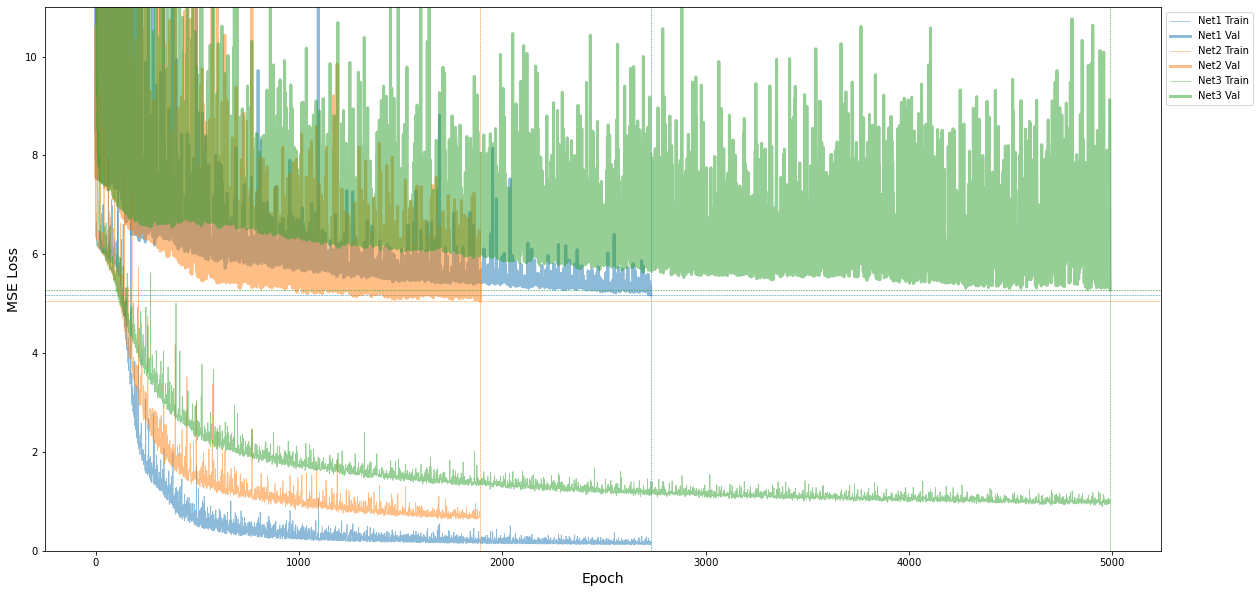

In [20]:
nets = [
    (net_regr1,'Net1'),
    (net_regr2,'Net2'),
    (net_regr3,'Net3'),
#     (net_regr4,'Net4'),
#     (net_regr5,'Net5'),
#     (net_regr6,'Net6'),
]

sk_loss_plot(nets)

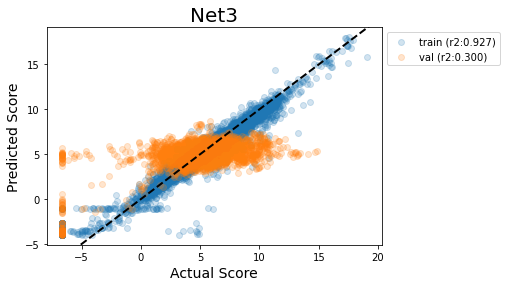

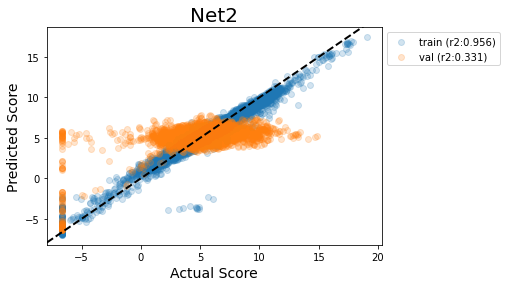

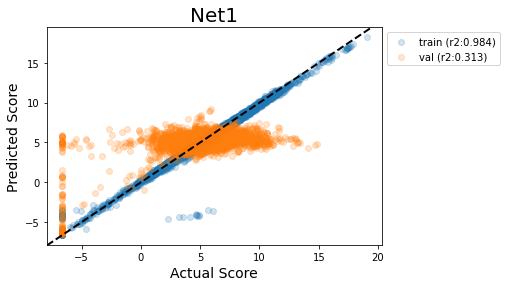

In [21]:
view_preds(nets[::-1])

# Next ideas
* Retry with low expressed genes cut out
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one